# Step 5 - Analysis of bicycle network results
## Project: Growing Urban Bicycle Networks with LTNs

This notebook takes the existing infrastructure, the results from 03_poi_based_generation and calculates/analyzes a number of measures:
* cost (length)
* coverage  
* directness  
* efficiency
* overlap with existing networks
* cyclable trips

TODO

- Speeding up
    - The `get_composite_lcc_length` funciton is pretty slow currently!
    - Producing buffers for coverage analysis is very slow
    - Coverage very slow
- bikeable trips metric
- find neighbourhoods where large amounts of residiental streets are used to potentially convert to LTNs?
- only runs for one place at at time currently (my bad coding skills + getting stuck down rabbitholes!)

In [1]:
# import libraries
from src import utils
PATH = utils.PATH # shortening the var name so that we don't have to change it below

# System
import csv
import os
import dill as pickle
import itertools
import random
from collections import defaultdict
import pprint
pp = pprint.PrettyPrinter(indent=4)
from tqdm.notebook import tqdm
import glob
from concurrent.futures import ThreadPoolExecutor
from copy import deepcopy
import yaml
import json

# Math/Data
import numpy as np
import pandas as pd


# Network
import networkx as nx

# Plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Geo
import osmnx as ox
ox.settings.log_file = True
ox.settings.requests_timeout = 300
ox.settings.logs_folder = PATH["logs"]
import geopandas as gpd
import json


## Preliminaries

### Parameters

In [2]:
debug = False # If True, will produce plots and/or verbose output to double-check
# if not debug: # Only do this if sure the code is bug-free!
#     warnings.filterwarnings('ignore')
rerun_existing = True # If True, will re-run the costly analysis of existing infra even if files already exist.
rerun = True # If True, recompute the analysis. If false, just re-make the plots

In [3]:
params = yaml.load(
    open("../parameters/parameters.yml"), 
    Loader=yaml.FullLoader)
osmnxparameters = json.load(open("../parameters/osmnxparameters.json", "r"))
plotparam = json.load(open("../parameters/plotparam.json", "r"))
plotparam_analysis = json.load(open("../parameters/plotparam_analysis.json", "r"))

### Network weighting by tags

In [4]:
tag_lts = json.load(open("../parameters/tag_lts.json", "r"))
distance_cost = json.load(open("../parameters/distance_cost.json", "r"))

### Load Cities

In [5]:
# load cities
cities = utils.load_cities(PATH, debug)

## Loading

### Load Results

In [6]:
# betweenness 
betweenness_results = {}
for scenario in params["scenarios"]:
    betweenness_results[scenario] = {}
    for placeid in cities:
        filename = (PATH["results"] + placeid + "/" + scenario + "/" + f"{placeid}_poi_{params['poi_source']}_betweenness_weighted_" + scenario + ".pickle")
        abs_path = os.path.abspath(filename)
        if os.path.exists(abs_path):
            with open(abs_path, "rb") as f:
                betweenness_results[scenario][placeid] = pickle.load(f)
        else:
            print(f"File {abs_path} does not exist.")
            print("Please run the betweenness analysis first.")
            print(f"No betweenness files found for {placeid} in scenario {scenario}.")

In [7]:
# random (many runs to get a distribution)
random_results = {}
for scenario in params["scenarios"]:
    random_results[scenario] = {}
    for placeid in cities:
        pattern = (PATH["results"] + placeid + "/" + scenario + "/" +
                   f"{placeid}_poi_{params['poi_source']}_random_weighted_{scenario}_run*.pickle")
        random_files = sorted(glob.glob(os.path.abspath(pattern)))[:3]  # only take the first 3 whilst we debug :D
        if random_files:
            random_results[scenario][placeid] = []
            for fn in random_files:
                abs_path = os.path.abspath(fn)
                with open(abs_path, "rb") as f:
                    res = pickle.load(f)
                random_results[scenario][placeid].append(res)
        else:
            print(f"No random files found for {placeid} in scenario {scenario}.")
            print("Please run the random growth analysis first.")


In [8]:
# demand
demand_results = {}
for scenario in params["scenarios"]:
    demand_results[scenario] = {}
    for placeid in cities:
        filename = (PATH["results"] + placeid + "/" + scenario + "/" + f"{placeid}_poi_{params['poi_source']}_demand_weighted_" + scenario + ".pickle")
        abs_path = os.path.abspath(filename)
        if os.path.exists(abs_path):
            with open(abs_path, "rb") as f:
                demand_results[scenario][placeid] = pickle.load(f)
        else:
            print(f"File {abs_path} does not exist.")
            print("Please run the demand analysis first.")
            print(f"No demand files found for {placeid} in scenario {scenario}.")


In [9]:
# demand LTN priority
demand_ltn_priority_results = {}
for scenario in params["scenarios"]:
    demand_ltn_priority_results[scenario] = {}
    for placeid in cities:
        filename = (PATH["results"] + placeid + "/" + scenario + "/" + f"{placeid}_poi_{params['poi_source']}_demand_ltn_priority_weighted_" + scenario + ".pickle")
        abs_path = os.path.abspath(filename)
        if os.path.exists(abs_path):
            with open(abs_path, "rb") as f:
                demand_ltn_priority_results[scenario][placeid] = pickle.load(f)
        else:
            print(f"File {abs_path} does not exist.")
            print("Please run the demand LTN priority analysis first.")
            print(f"No demand LTN priority files found for {placeid} in scenario {scenario}.")


In [10]:
# betweenness LTN priority
betweenness_ltn_priority_results = {}
for scenario in params["scenarios"]:
    betweenness_ltn_priority_results[scenario] = {}
    for placeid in cities:
        filename = (PATH["results"] + placeid + "/" + scenario + "/" + f"{placeid}_poi_{params['poi_source']}_betweenness_ltn_priority_weighted_" + scenario + ".pickle")
        abs_path = os.path.abspath(filename)
        if os.path.exists(abs_path):
            with open(abs_path, "rb") as f:
                betweenness_ltn_priority_results[scenario][placeid] = pickle.load(f)
        else:
            print(f"File {abs_path} does not exist.")
            print("Please run the betweenness LTN priority analysis first.")
            print(f"No betweenness LTN priority files found for {placeid} in scenario {scenario}.")


Find investment level, split results into GTs, GT_abstracts 

In [11]:
for scenario_name in params["scenarios"]:
    for placeid in cities:

        # Demand 
        if placeid in demand_results.get(scenario_name, {}):
            demand_dict = demand_results[scenario_name][placeid]
            investment_levels_demand = demand_dict["prune_quantiles"]
            GTs_demand               = demand_dict["GTs"]
            GT_abstracts_demand      = demand_dict["GT_abstracts"]
        else:
            print(f"No demand results for {placeid} in scenario '{scenario_name}'")
            investment_levels_demand = []
            GTs_demand               = []
            GT_abstracts_demand      = []


        # Betweenness‐LTN‐priority 
        if placeid in betweenness_ltn_priority_results.get(scenario_name, {}):
            betweenness_ltn_dict = betweenness_ltn_priority_results[scenario_name][placeid]
            investment_levels_betw = betweenness_ltn_dict["prune_quantiles"]
            GTs_betw               = betweenness_ltn_dict["GTs"]
            GT_abstracts_betw      = betweenness_ltn_dict["GT_abstracts"]
        else:
            # e.g. scenario == "no_ltn_scenario" has no betweenness‐LTN‐priority data
            investment_levels_betw = []
            GTs_betw               = []
            GT_abstracts_betw      = []

        # Betweenness
        if placeid in betweenness_results.get(scenario_name, {}):
            betweenness_dict = betweenness_results[scenario_name][placeid]
            investment_levels_betweenness = betweenness_dict["prune_quantiles"]
            GTs_betweenness               = betweenness_dict["GTs"]
            GT_abstracts_betweenness      = betweenness_dict["GT_abstracts"]
        else:
            investment_levels_betweenness = []
            GTs_betweenness               = []
            GT_abstracts_betweenness      = []

        # Demand‐LTN‐priority 
        if placeid in demand_ltn_priority_results.get(scenario_name, {}):
            dem_ltn_dict = demand_ltn_priority_results[scenario_name][placeid]
            investment_levels_dem_ltn = dem_ltn_dict["prune_quantiles"]
            GTs_dem_ltn               = dem_ltn_dict["GTs"]
            GT_abstracts_dem_ltn      = dem_ltn_dict["GT_abstracts"]
        else:
            investment_levels_dem_ltn = []
            GTs_dem_ltn               = []
            GT_abstracts_dem_ltn      = []

        # Random‐runs (loads all run*.pickle files)
        random_runs_list = random_results.get(scenario_name, {}).get(placeid, [])
        if random_runs_list:
            all_GTs_random       = [run_dict["GTs"]          for run_dict in random_runs_list]
            all_GTabs_random      = [run_dict["GT_abstracts"]  for run_dict in random_runs_list]
            investment_levels_random = random_runs_list[0]["prune_quantiles"]
        else:
            all_GTs_random          = []
            all_GTabs_random         = []
            investment_levels_random = []



### Load existing networks, nodes, GeoDataframe



In [12]:
G_biketracks_dict               = {}  # (placeid, scenario) → biketrack graph
G_biketrack_no_ltns_dict       = {}  # (placeid, scenario) → biketrack_no_ltn graph
G_biketrackcaralls_dict        = {}  # (placeid, scenario) → biketrackcarall graph
G_biketrackcarall_edges_dict    = {}  # (placeid, scenario) → GeoDataFrame of biketrackcarall edges
boundary_gdfs               = {}  # placeid → boundary GeoDataFrame (same for all scenarios)
tess_points_dict            = {}  # (placeid, scenario) → tessellation points GeoDataFrame
ltn_points_dict             = {}  # (placeid, scenario) → LTN points GeoDataFrame
combined_points_dict        = {}  # (placeid, scenario) → combined points GeoDataFrame

for scenario in params["scenarios"]:
    for placeid, placeinfo in cities.items():
        base_folder = os.path.join(PATH["data"], placeid, scenario)

        # Load biketrack graph
        biketrack_gpkg = os.path.join(base_folder, f"{placeid}_biketrack.gpkg")
        if os.path.exists(biketrack_gpkg):
            G_biketrack = utils.ox_gpkg_to_graph(biketrack_gpkg)
            G_biketrack.remove_nodes_from(list(nx.isolates(G_biketrack)))
            G_biketracks_dict[(placeid, scenario)] = G_biketrack
        else:
            print(f"Missing: {biketrack_gpkg}")
            G_biketracks_dict[(placeid, scenario)] = None

        # Load biketrack_no_ltn graph
        biketrack_no_ltn_gpkg = os.path.join(base_folder, f"{placeid}_biketrack_no_ltn.gpkg")
        if os.path.exists(biketrack_no_ltn_gpkg):
            G_no_ltn = utils.ox_gpkg_to_graph(biketrack_no_ltn_gpkg)
            G_no_ltn.remove_nodes_from(list(nx.isolates(G_no_ltn)))
            G_biketrack_no_ltns_dict[(placeid, scenario)] = G_no_ltn
        else:
            print(f"Missing: {biketrack_no_ltn_gpkg}")
            G_biketrack_no_ltns_dict[(placeid, scenario)] = None

        # Load biketrackcarall graph
        biketrackcarall_gpkg = os.path.join(base_folder, f"{placeid}_biketrackcarall.gpkg")
        if os.path.exists(biketrackcarall_gpkg):
            G_carall = utils.ox_gpkg_to_graph(biketrackcarall_gpkg)
            G_carall.remove_nodes_from(list(nx.isolates(G_carall)))
            G_biketrackcaralls_dict[(placeid, scenario)] = G_carall

            # also store edges GeoDataFrame
            edges_gdf = ox.graph_to_gdfs(G_carall, nodes=False)
            G_biketrackcarall_edges_dict[(placeid, scenario)] = edges_gdf
        else:
            print(f"Missing: {biketrackcarall_gpkg}")
            G_biketrackcaralls_dict[(placeid, scenario)] = None
            G_biketrackcarall_edges_dict[(placeid, scenario)] = None

        #  Load boundary once per placeid (it won’t change by scenario)
        if placeid not in boundary_gdfs:
            boundary_gdf = ox.geocode_to_gdf(placeinfo["nominatimstring"])
            boundary_gdfs[placeid] = boundary_gdf

        # get nodes
        tess_points_gpkg = os.path.join(base_folder, f"{placeid}_tessellation_points.gpkg")
        if os.path.exists(tess_points_gpkg):
            tess_points = gpd.read_file(tess_points_gpkg)
            tess_points_dict[(placeid, scenario)] = tess_points
        else:
            print(f"Missing: {tess_points_gpkg}")
            tess_points_dict[(placeid, scenario)] = None
        
        # get ltn points
        if scenario != "no_ltn_scenario":
            ltn_points_gpkg = os.path.join(base_folder, f"{placeid}_ltn_points.gpkg")
            if os.path.exists(ltn_points_gpkg):
                ltn_points = gpd.read_file(ltn_points_gpkg)
                ltn_points_dict[(placeid, scenario)] = ltn_points
            else:
                print(f"Missing: {ltn_points_gpkg}")
                ltn_points_dict[(placeid, scenario)] = None
        
        # get combined points
        combined_points_gpkg = os.path.join(base_folder, f"{placeid}_combined_points.gpkg")
        if os.path.exists(combined_points_gpkg):
            combined_points = gpd.read_file(combined_points_gpkg)
            combined_points_dict[(placeid, scenario)] = combined_points
        else:
            print(f"Missing: {combined_points_gpkg}")
            combined_points_dict[(placeid, scenario)] = None

        # get all neighbourhoods (ragardless of their low traffic status. This doesn't change by scenario)
        all_neighbourhoods = gpd.read_file(PATH["data"] + placeid + "/" + 'neighbourhoods_'+  placeid + '.gpkg')
        all_neighbourhoods_centroids = all_neighbourhoods.geometry.centroid
        all_neighbourhoods_centroids = gpd.GeoDataFrame(geometry= all_neighbourhoods_centroids, crs=all_neighbourhoods.crs)



Missing: ../../bikenwgrowth_external/data/newcastle\no_ltn_scenario\newcastle_tessellation_points.gpkg


C:\Users\b8008458\AppData\Local\Temp\ipykernel_24060\1656686378.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  all_neighbourhoods_centroids = all_neighbourhoods.geometry.centroid


Missing: ../../bikenwgrowth_external/data/newcastle\current_ltn_scenario\newcastle_tessellation_points.gpkg


C:\Users\b8008458\AppData\Local\Temp\ipykernel_24060\1656686378.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  all_neighbourhoods_centroids = all_neighbourhoods.geometry.centroid


Missing: ../../bikenwgrowth_external/data/newcastle\more_ltn_scenario\newcastle_tessellation_points.gpkg


C:\Users\b8008458\AppData\Local\Temp\ipykernel_24060\1656686378.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  all_neighbourhoods_centroids = all_neighbourhoods.geometry.centroid


In [13]:
# setup

def csv_to_ox(p, placeid, parameterid):
    '''
    Load graph from csv files (nodes and edge)
    Include OSMID, length, highway, x, y attributes
    '''

    prefix = placeid + '_' + parameterid
    compress = utils.check_extract_zip(p, prefix)
    
    with open(p + prefix + '_edges.csv', 'r') as f:
        header = f.readline().strip().split(",")
        lines = []
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = str(eval(line_list[header.index("osmid")])[0]) if isinstance(eval(line_list[header.index("osmid")]), list) else line_list[header.index("osmid")]
            length = str(eval(line_list[header.index("length")])[0]) if isinstance(eval(line_list[header.index("length")]), list) else line_list[header.index("length")]
            highway = line_list[header.index("highway")]
            if highway.startswith("[") and highway.endswith("]"):
                highway = highway.strip("[]").split(",")[0].strip(" '")
            line_string = f"{line_list[header.index('u')]} {line_list[header.index('v')]} {osmid} {length} {highway}"
            lines.append(line_string)
        G = nx.parse_edgelist(lines, nodetype=int, data=(("osmid", int), ("length", float), ("highway", str)), create_using=nx.MultiDiGraph)
    
    with open(p + prefix + '_nodes.csv', 'r') as f:
        header = f.readline().strip().split(",")
        values_x = {}
        values_y = {}
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = int(line_list[header.index("osmid")])
            values_x[osmid] = float(line_list[header.index("x")])
            values_y[osmid] = float(line_list[header.index("y")])
        nx.set_node_attributes(G, values_x, "x")
        nx.set_node_attributes(G, values_y, "y")
    
    if compress:
        os.remove(p + prefix + '_nodes.csv')
        os.remove(p + prefix + '_edges.csv')
    return G



# Analyse

### Analysis saving setup

In [14]:
analysis_res_pickle_paths = {}  
analysis_res_json_paths    = {}  
analysis_results          = {}
for scenario in params["scenarios"]:
    analysis_res_pickle_paths[scenario] = os.path.join(PATH["results"] + placeid + "/" + scenario + "/" + f"{placeid}_{scenario}_analysis_results.pickle")
    analysis_res_json_paths[scenario] = os.path.join(PATH["results"], placeid + "/" + scenario + "/" + f"{placeid}_{scenario}_analysis_results.json")
    analysis_results[scenario] = {}


### Prelimiary Length

Length - finding the distance of the connected network, along with the investment distance (length - existing infrastructure)

In [15]:
for scenario in params["scenarios"]:
    G_biketrack = G_biketracks_dict.get((placeid, scenario))
    G_biketrack_no_ltn = G_biketrack_no_ltns_dict.get((placeid, scenario))
    GTs = demand_results.get(scenario, {}).get(placeid, {}).get("GTs", [])

    if not (G_biketrack and G_biketrack_no_ltn and GTs):
        print(f"Missing data for {placeid} - {scenario}. Skipping.")
        continue

    # File paths
    analysis_res_pickle = os.path.join(PATH["results"], placeid, scenario, f"{placeid}_{scenario}_analysis_results.pickle")
    analysis_res_csv    = os.path.join(PATH["results"], placeid, scenario, f"{placeid}_{scenario}_analysis_results.csv")
    output_path         = os.path.join(PATH["plots"], placeid, scenario, "allLengths.png")

    # Load existing results
    if os.path.exists(analysis_res_pickle):
        with open(analysis_res_pickle, 'rb') as f:
            analysis_results[scenario] = pickle.load(f)
    else:
        analysis_results[scenario] = {}

    # Calculations
    total_biketrack        = sum(nx.get_edge_attributes(G_biketrack, 'length').values())
    total_biketrack_no_ltn = sum(nx.get_edge_attributes(G_biketrack_no_ltn, 'length').values())
    total_network          = sum(nx.get_edge_attributes(GTs[-1], 'length').values())
    investment_length      = sum(
        data.get('length', 0) * distance_cost.get(data.get('highway', 'unclassified'), 1)
        for _, _, data in GTs[-1].edges(data=True))

    length_stats = {'length_comparison_labels': [ "Existing Cycle Infrastructure (Including LTNs)", "Existing Cycle Infrastructure (Excluding LTNs)", "LTNs", "Fully Connected Cycle Network", "Investment Distance"],
        'length_comparison_values': [total_biketrack, total_biketrack_no_ltn, abs(total_biketrack - total_biketrack_no_ltn), total_network, investment_length],
        'length_comparison_colors': ['deepskyblue'] * 5,
        'total_network_length': total_network,
        'total_biketrack_length': total_biketrack,
        'total_biketrack_no_ltn_length': total_biketrack_no_ltn,
        'length_difference': abs(total_biketrack - total_biketrack_no_ltn),
        'total_investment_length': investment_length}

    # Save to pickle & CSV
    analysis_results[scenario].update(length_stats)
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results[scenario], f)
    analysis_res_json = os.path.join(PATH["results"], placeid, scenario, f"{placeid}_{scenario}_analysis_results.json")
    with open(analysis_res_json, 'w') as f:
        json.dump(analysis_results[scenario], f, indent=2)
    # removed csv - can't take columns with different lengths
    #pd.DataFrame({k: [v] for k, v in analysis_results[scenario].items()}).to_csv(analysis_res_csv, index=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(
        analysis_results[scenario]['length_comparison_labels'],
        analysis_results[scenario]['length_comparison_values'],
        color=analysis_results[scenario]['length_comparison_colors']
    )
    plt.xlabel('Network Type')
    plt.ylabel('Total Length (meters)')
    plt.title(f'{placeid} - {scenario} - Lengths of Cycle Networks')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()


    ltn_difference = abs(total_biketrack - total_biketrack_no_ltn)
    labels = ["Total Cycle Infrastructure", "Protected Cycle Infrastructure","LTNs"]
    values = [total_biketrack, total_biketrack_no_ltn, ltn_difference]
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['deepskyblue'] * 3)
    plt.xlabel('Network Type')
    plt.ylabel('Total Length (meters)')
    plt.title(f'{placeid} - {scenario} - Total Lengths of Cycle Infrastructure')
    plt.tight_layout()
    output_path_total = os.path.join(PATH["plots"], placeid, scenario, "TotalLengthsCycleNet.png")
    plt.savefig(output_path_total, dpi=300)
    plt.close()
    
    print(f"Completed {placeid} - {scenario}")



Completed newcastle - no_ltn_scenario
Completed newcastle - current_ltn_scenario
Completed newcastle - more_ltn_scenario


#### Pure length - how is the budget used per iteration

In [79]:
for scenario in params["scenarios"]:
    # load scenario-specific results and data
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)
    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GTs", [])
    GTs_demand = demand_results[scenario].get(placeid, {}).get("GTs", [])
    if scenario != "no_ltn_scenario":
        GTs_demand_ltn_priority = demand_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
        GTs_betweenness_ltn_priority = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
    random_runs = random_results[scenario].get(placeid, [])

    if rerun or 'total_lengths' not in analysis_results[scenario]:
        results_list = []
        total_lengths_betweenness = utils.compute_total_lengths(GTs_betweenness)
        total_lengths_demand = utils.compute_total_lengths(GTs_demand)
        total_lengths_random_runs = [utils.compute_total_lengths(run["GTs"]) for run in random_runs]
        total_lengths_random_mean = np.mean(total_lengths_random_runs, axis=0).tolist()

        # save results
        results_list.append(("Betweenness Growth - Total Length", total_lengths_betweenness))
        results_list.append(("Demand Growth - Total Length", total_lengths_demand))
        for i, run_lengths in enumerate(total_lengths_random_runs):
            results_list.append((f"Random Run {i+1} - Total Length", run_lengths))
        results_list.append(("Random Growth (mean) - Total Length", total_lengths_random_mean))
        if scenario != "no_ltn_scenario":
            total_lengths_demand_ltn_priority = utils.compute_total_lengths(GTs_demand_ltn_priority)
            total_lengths_betweenness_ltn_priority = utils.compute_total_lengths(GTs_betweenness_ltn_priority)
            results_list.append(("Demand LTN Priority Growth - Total Length", total_lengths_demand_ltn_priority))
            results_list.append(("Betweenness LTN Priority Growth - Total Length", total_lengths_betweenness_ltn_priority))
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Updated analysis results for {scenario} in {placeid}")

    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Total Length"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color='lightgray', linewidth=1, alpha=0.5)
        else:
            break
    plt.plot(analysis_results[scenario]['Random Growth (mean) - Total Length'], linestyle='--', linewidth=2, label='Random Growth (mean)')
    plt.plot(analysis_results[scenario]['Betweenness Growth - Total Length'], '-', label='Betweenness Growth', color='orange')
    plt.plot(analysis_results[scenario]['Demand Growth - Total Length'], '-.', label='Demand Growth', color='red')
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]['Demand LTN Priority Growth - Total Length'], ':', label='Demand LTN Priority Growth', color='green')
        plt.plot(analysis_results[scenario]['Betweenness LTN Priority Growth - Total Length'], '-', label='Betweenness LTN Priority Growth', color='purple')
    plt.xlabel('Investment Iteration')
    plt.ylabel('Total Length (meters)')
    plt.title(f'Length of Invested Cycle Network for {scenario} - {placeid}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    output_path = os.path.join(PATH["plots"], placeid, scenario, "L_of_Investment.png")
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Plots saved for {placeid} - {scenario}")

Updated analysis results for no_ltn_scenario in newcastle
Plots saved for newcastle - no_ltn_scenario
Updated analysis results for current_ltn_scenario in newcastle
Plots saved for newcastle - current_ltn_scenario
Updated analysis results for more_ltn_scenario in newcastle
Plots saved for newcastle - more_ltn_scenario


Deviation from random - pure length

In [80]:
for scenario in params["scenarios"]:
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)

    if rerun or not any(k.endswith("Deviation from Random") for k in analysis_results[scenario]):
        baseline = analysis_results[scenario]['Random Growth (mean) - Total Length']
        results_list = []
        # Calculate deviation from random baseline
        results_list.append((
            "Betweenness Growth - Total Length Deviation from Random",
            utils.compute_abs_deviation(analysis_results[scenario]["Betweenness Growth - Total Length"], baseline)))
        results_list.append((
            "Demand Growth - Total Length Deviation from Random",
            utils.compute_abs_deviation(analysis_results[scenario]["Demand Growth - Total Length"], baseline)))

        # Calculate mean deviation for random runs
        random_runs_keys = [key for key in analysis_results[scenario] if key.startswith("Random Run") and "Total Length" in key]
        random_runs = [analysis_results[scenario][key] for key in random_runs_keys]
        random_runs_deviations = [utils.compute_abs_deviation(run, baseline) for run in random_runs]
        random_deviations_mean = np.mean(random_runs_deviations, axis=0).tolist()
        results_list.append(("Random Growth (mean) - Total Length Deviation from Random", random_deviations_mean))
        if scenario != "no_ltn_scenario":
            results_list.append(("Demand LTN Priority Growth - Total Length Deviation from Random",
                utils.compute_abs_deviation(analysis_results[scenario]["Demand LTN Priority Growth - Total Length"], baseline)))
            results_list.append(("Betweenness LTN Priority Growth - Total Length Deviation from Random",
                utils.compute_abs_deviation(analysis_results[scenario]["Betweenness LTN Priority Growth - Total Length"], baseline)))

        # Add random runs deviations
        for i, dev in enumerate(random_runs_deviations):
            results_list.append((f"Random Run {i+1} - Total Length Deviation from Random", dev))

        # Save all results as list of (label, data)
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Saved absolute deviation results for {scenario} in {placeid}")





     # Plotting
    plt.figure(figsize=(10, 6))
    for key in analysis_results[scenario]:
        if key.startswith("Random Run") and "Deviation from Random" in key:
            plt.plot(analysis_results[scenario][key], color='lightgray', linewidth=1, alpha=0.4)
    plt.axhline(0, color='blue', linestyle='--', linewidth=2, label='Random Growth (mean)')
    plot_lines = [
        ("Betweenness Growth - Total Length Deviation from Random", '-', 'orange', 'Betweenness Growth'),
        ("Demand Growth - Total Length Deviation from Random", '-.', 'red', 'Demand Growth'),]
    if scenario != "no_ltn_scenario": plot_lines += [ ("Demand LTN Priority Growth - Total Length Deviation from Random", ':', 'green', 'Demand LTN Priority Growth'), ("Betweenness LTN Priority Growth - Total Length Deviation from Random", '-', 'purple', 'Betweenness LTN Priority Growth'),]
    for key, ls, color, label in plot_lines:
        plt.plot(analysis_results[scenario][key], linestyle=ls, color=color, label=label)
    plt.xlabel('Investment Iteration')
    plt.ylabel('Deviation from Random Growth Baseline (meters)')
    plt.title(f'Deviation from Random Growth Baseline for {scenario} - {placeid}')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    output_path = os.path.join(PATH["plots"], placeid, scenario, "abs_dev_from_random_length.png")
    plt.savefig(output_path, dpi=300)
    plt.close()


Saved absolute deviation results for no_ltn_scenario in newcastle
Saved absolute deviation results for current_ltn_scenario in newcastle
Saved absolute deviation results for more_ltn_scenario in newcastle


#### "Actual" investment length - how much do we actually need to use to close gaps

Calculate length, minus the existing infrastructure

#### Find how much we actually need to invest

In [ ]:
for scenario in params["scenarios"]:
    # Load results
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)

    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GTs", [])
    GTs_demand = demand_results[scenario].get(placeid, {}).get("GTs", [])
    if scenario != "no_ltn_scenario":
        GTs_demand_ltn_priority = demand_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
        GTs_betweenness_ltn_priority = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
    random_runs = random_results[scenario].get(placeid, [])

    if rerun or "Betweenness Growth - Total Investment Length" not in analysis_results[scenario]:
        results_list = []

        total_investment_betweenness = utils.compute_total_investment_lengths(GTs_betweenness, distance_cost)
        total_investment_demand = utils.compute_total_investment_lengths(GTs_demand, distance_cost)
        random_runs_investments = [utils.compute_total_investment_lengths(run["GTs"], distance_cost) for run in random_runs]
        random_investment_mean = np.mean(random_runs_investments, axis=0).tolist()

        results_list.append(("Betweenness Growth - Total Investment Length", total_investment_betweenness))
        results_list.append(("Demand Growth - Total Investment Length", total_investment_demand))
        for i, run_lengths in enumerate(random_runs_investments):
            results_list.append((f"Random Run {i+1} - Total Investment Length", run_lengths))
        results_list.append(("Random Growth (mean) - Total Investment Length", random_investment_mean))

        if scenario != "no_ltn_scenario":
            total_investment_demand_ltn_priority = utils.compute_total_investment_lengths(GTs_demand_ltn_priority, distance_cost)
            total_investment_betweenness_ltn_priority = utils.compute_total_investment_lengths(GTs_betweenness_ltn_priority, distance_cost)
            results_list.append(("Demand LTN Priority Growth - Total Investment Length", total_investment_demand_ltn_priority))
            results_list.append(("Betweenness LTN Priority Growth - Total Investment Length", total_investment_betweenness_ltn_priority))

        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Updated investment cost results for {scenario} in {placeid}")

    # Plotting
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Total Investment Length"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color='lightgray', linewidth=1, alpha=0.5)
        else:
            break
    plt.plot(analysis_results[scenario]["Random Growth (mean) - Total Investment Length"], linestyle='--', linewidth=2, color='blue', label='Random Growth (mean)')
    plt.plot(analysis_results[scenario]["Betweenness Growth - Total Investment Length"], '-', color='orange', label='Betweenness Growth')
    plt.plot(analysis_results[scenario]["Demand Growth - Total Investment Length"], '-.', color='red', label='Demand Growth')
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Total Investment Length"], ':', color='green', label='Demand LTN Priority Growth')
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Total Investment Length"], '-', color='purple', label='Betweenness LTN Priority Growth')

    plt.xlabel('Investment Iteration')
    plt.ylabel('Total Investment Cost (Meters)')
    plt.title(f'Total Investment Cost per Growth Strategy for {scenario} - {placeid}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "total_investment_cost.png")
    plt.savefig(output_path, dpi=300)
    plt.close()


In [ ]:
for scenario in params["scenarios"]:
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)

    if rerun or not any(k.endswith("Deviation from Random - Total Investment Length") for k in analysis_results[scenario]):
        baseline = analysis_results[scenario]["Random Growth (mean) - Total Investment Length"]
        results_list = []

        # Compute deviations from random baseline
        results_list.append(("Betweenness Growth - Deviation from Random - Total Investment Length",
            utils.compute_abs_deviation(analysis_results[scenario]["Betweenness Growth - Total Investment Length"], baseline)))
        results_list.append(("Demand Growth - Deviation from Random - Total Investment Length",
            utils.compute_abs_deviation(analysis_results[scenario]["Demand Growth - Total Investment Length"], baseline)))
        random_keys = [key for key in analysis_results[scenario] if key.startswith("Random Run") and "Total Investment Length" in key]
        random_runs = [analysis_results[scenario][key] for key in random_keys]
        random_deviations = [utils.compute_abs_deviation(run, baseline) for run in random_runs]
        mean_random_dev = np.mean(random_deviations, axis=0).tolist()
        results_list.append(("Random Growth (mean) - Deviation from Random - Total Investment Length", mean_random_dev))

        if scenario != "no_ltn_scenario":
            results_list.append((
                "Demand LTN Priority Growth - Deviation from Random - Total Investment Length",
                utils.compute_abs_deviation(analysis_results[scenario]["Demand LTN Priority Growth - Total Investment Length"], baseline)))
            results_list.append((
                "Betweenness LTN Priority Growth - Deviation from Random - Total Investment Length",
                utils.compute_abs_deviation(analysis_results[scenario]["Betweenness LTN Priority Growth - Total Investment Length"], baseline)))
        for i, dev in enumerate(random_deviations):
            results_list.append((f"Random Run {i+1} - Deviation from Random - Total Investment Length", dev))
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario].update({label: data for label, data in results_list})
        print(f"Saved deviation-from-random investment cost results for {scenario} in {placeid}")






    # Plotting
    plt.figure(figsize=(10, 6))
    for key in analysis_results[scenario]:
        if key.startswith("Random Run") and "Deviation from Random - Total Investment Length" in key:
            plt.plot(analysis_results[scenario][key], color='lightgray', linewidth=1, alpha=0.4)
    plt.axhline(0, color='blue', linestyle='--', linewidth=2, label='Random Growth (mean)')

    plot_lines = [("Betweenness Growth - Deviation from Random - Total Investment Length", '-', 'orange', 'Betweenness Growth'),
        ("Demand Growth - Deviation from Random - Total Investment Length", '-.', 'red', 'Demand Growth'),]
    if scenario != "no_ltn_scenario":
        plot_lines += [ ("Demand LTN Priority Growth - Deviation from Random - Total Investment Length", ':', 'green', 'Demand LTN Priority Growth'),
                       ("Betweenness LTN Priority Growth - Deviation from Random - Total Investment Length", '-', 'purple', 'Betweenness LTN Priority Growth')]

    for key, linestyle, color, label in plot_lines:
        plt.plot(analysis_results[scenario][key], linestyle=linestyle, color=color, label=label)

    plt.xlabel('Investment Iteration')
    plt.ylabel('Deviation from Random Growth Baseline (meters × weight)')
    plt.title(f'Deviation from Random Growth Baseline (Total Investment Cost) for {scenario} - {placeid}')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "abs_dev_from_random_investment_cost.png")
    plt.savefig(output_path, dpi=300)
    plt.close()


Find comparison between how much we need against full route lengths

Find differance between network size and required investment

In [ ]:
for scenario in params["scenarios"]:
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)

    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GTs", [])
    GTs_demand = demand_results[scenario].get(placeid, {}).get("GTs", [])
    if scenario != "no_ltn_scenario":
        GTs_demand_ltn_priority = demand_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
        GTs_betweenness_ltn_priority = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
    random_runs = random_results[scenario].get(placeid, [])

    if rerun or "Betweenness Growth - Length Difference" not in analysis_results[scenario]:
        results_list = []

        length_diff_betweenness = utils.compute_length_difference(GTs_betweenness)
        length_diff_demand = utils.compute_length_difference(GTs_demand)
        random_run_differences = [utils.compute_length_difference(run["GTs"]) for run in random_runs]
        random_diff_mean = np.mean(random_run_differences, axis=0).tolist()

        results_list.append(("Betweenness Growth - Length Difference", length_diff_betweenness))
        results_list.append(("Demand Growth - Length Difference", length_diff_demand))
        for i, run_diff in enumerate(random_run_differences):
            results_list.append((f"Random Run {i+1} - Length Difference", run_diff))
        results_list.append(("Random Growth (mean) - Length Difference", random_diff_mean))

        if scenario != "no_ltn_scenario":
            length_diff_demand_ltn = utils.compute_length_difference(GTs_demand_ltn_priority)
            length_diff_betweenness_ltn = utils.compute_length_difference(GTs_betweenness_ltn_priority)
            results_list.append(("Demand LTN Priority Growth - Length Difference", length_diff_demand_ltn))
            results_list.append(("Betweenness LTN Priority Growth - Length Difference", length_diff_betweenness_ltn))

        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Saved length difference results for {scenario} in {placeid}")





    # Plotting
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Length Difference"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color='lightgray', linewidth=1, alpha=0.4)
        else:
            break

    plt.plot(analysis_results[scenario]["Random Growth (mean) - Length Difference"], linestyle='--', linewidth=2, color='blue', label='Random Growth (mean)')
    plt.plot(analysis_results[scenario]["Betweenness Growth - Length Difference"], '-', color='orange', label='Betweenness Growth')
    plt.plot(analysis_results[scenario]["Demand Growth - Length Difference"], '-.', color='red', label='Demand Growth')

    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Length Difference"], ':', color='green', label='Demand LTN Priority Growth')
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Length Difference"], '-', color='purple', label='Betweenness LTN Priority Growth')

    plt.xlabel("Investment Iteration")
    plt.ylabel("Length Difference (meters)")
    plt.title(f"Difference Between Total Network Size and Investment Size for {scenario} - {placeid}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "length_difference.png")
    plt.savefig(output_path, dpi=300)
    plt.close()


In [ ]:
for scenario in params["scenarios"]:
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)

    if rerun or "Betweenness Growth - Deviation from Random Length Difference" not in analysis_results[scenario]:
        results_list = []
        baseline = np.array(analysis_results[scenario]["Random Growth (mean) - Length Difference"])
        deviation_betweenness = (np.array(analysis_results[scenario]["Betweenness Growth - Length Difference"]) - baseline).tolist()
        deviation_demand = (np.array(analysis_results[scenario]["Demand Growth - Length Difference"]) - baseline).tolist()

        results_list.append(("Betweenness Growth - Deviation from Random Length Difference", deviation_betweenness))
        results_list.append(("Demand Growth - Deviation from Random Length Difference", deviation_demand))

        if scenario != "no_ltn_scenario":
            deviation_demand_ltn = (np.array(analysis_results[scenario]["Demand LTN Priority Growth - Length Difference"]) - baseline).tolist()
            deviation_betweenness_ltn = (np.array(analysis_results[scenario]["Betweenness LTN Priority Growth - Length Difference"]) - baseline).tolist()
            results_list.append(("Demand LTN Priority Growth - Deviation from Random Length Difference", deviation_demand_ltn))
            results_list.append(("Betweenness LTN Priority Growth - Deviation from Random Length Difference", deviation_betweenness_ltn))

        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario].update({k: v for k, v in results_list})
        print(f"Saved deviation-from-random length difference results for {scenario} in {placeid}")



    # Plotting
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Length Difference"
        if key in analysis_results[scenario]:
            run_dev = np.array(analysis_results[scenario][key]) - np.array(analysis_results[scenario]["Random Growth (mean) - Length Difference"])
            plt.plot(run_dev, color='lightgray', linewidth=1, alpha=0.4)
        else:
            break
    plt.axhline(0, color='blue', linestyle='--', linewidth=2, label='Random Growth (mean)')
    plt.plot(analysis_results[scenario]["Betweenness Growth - Deviation from Random Length Difference"], '-', color='orange', label='Betweenness Growth')
    plt.plot(analysis_results[scenario]["Demand Growth - Deviation from Random Length Difference"], '-.', color='red', label='Demand Growth')
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Deviation from Random Length Difference"], ':', color='green', label='Demand LTN Priority Growth')
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Deviation from Random Length Difference"], '-', color='purple', label='Betweenness LTN Priority Growth')
    plt.xlabel("Investment Iteration")
    plt.ylabel("Deviation from Random (meters)")
    plt.title(f"Deviation from Random Growth Strategy for {scenario} - {placeid}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    output_path = os.path.join(PATH["plots"], placeid, scenario, "length_difference_deviation_from_random.png")
    plt.savefig(output_path, dpi=300)
    plt.close()

In [ ]:
for scenario in params["scenarios"]:
    # Load paths and results for this scenario
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)

    # Load GTs data per growth strategy
    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GTs", [])
    GTs_demand = demand_results[scenario].get(placeid, {}).get("GTs", [])
    if scenario != "no_ltn_scenario":
        GTs_demand_ltn_priority = demand_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
        GTs_betweenness_ltn_priority = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
    random_runs = random_results[scenario].get(placeid, [])

    if rerun or 'total_lengths_vs_investment' not in analysis_results[scenario]:
        results_list = []

        # Compute total lengths and investment lengths for each growth type
        lengths_betweenness = utils.compute_total_lengths(GTs_betweenness)
        investment_betweenness = utils.compute_total_investment_lengths(GTs_betweenness, distance_cost)
        lengths_demand = utils.compute_total_lengths(GTs_demand)
        investment_demand = utils.compute_total_investment_lengths(GTs_demand, distance_cost)
        random_lengths_runs = [utils.compute_total_lengths(run["GTs"]) for run in random_runs]
        random_investment_runs = [utils.compute_total_investment_lengths(run["GTs"], distance_cost) for run in random_runs]
        random_lengths_mean = np.mean(random_lengths_runs, axis=0).tolist()
        random_investment_mean = np.mean(random_investment_runs, axis=0).tolist()
        # Append results 
        results_list.append(("Betweenness Growth - Total Length", lengths_betweenness))
        results_list.append(("Betweenness Growth - Total Investment Length", investment_betweenness))
        results_list.append(("Demand Growth - Total Length", lengths_demand))
        results_list.append(("Demand Growth - Total Investment Length", investment_demand))
        for i, (run_lengths, run_investment) in enumerate(zip(random_lengths_runs, random_investment_runs)):
            results_list.append((f"Random Run {i+1} - Total Length", run_lengths))
            results_list.append((f"Random Run {i+1} - Total Investment Length", run_investment))
        results_list.append(("Random Growth (mean) - Total Length", random_lengths_mean))
        results_list.append(("Random Growth (mean) - Total Investment Length", random_investment_mean))
        if scenario != "no_ltn_scenario":
            lengths_demand_ltn = utils.compute_total_lengths(GTs_demand_ltn_priority)
            investment_demand_ltn = utils.compute_total_investment_lengths(GTs_demand_ltn_priority, distance_cost)
            lengths_betweenness_ltn = utils.compute_total_lengths(GTs_betweenness_ltn_priority)
            investment_betweenness_ltn = utils.compute_total_investment_lengths(GTs_betweenness_ltn_priority, distance_cost)
            results_list.append(("Demand LTN Priority Growth - Total Length", lengths_demand_ltn))
            results_list.append(("Demand LTN Priority Growth - Total Investment Length", investment_demand_ltn))
            results_list.append(("Betweenness LTN Priority Growth - Total Length", lengths_betweenness_ltn))
            results_list.append(("Betweenness LTN Priority Growth - Total Investment Length", investment_betweenness_ltn))
        # Save all results
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Updated analysis results for {scenario} in {placeid}")

    # Plotting: investment length vs total length
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        len_key = f"Random Run {i} - Total Length"
        invest_key = f"Random Run {i} - Total Investment Length"
        if len_key in analysis_results[scenario] and invest_key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][len_key], analysis_results[scenario][invest_key], 
                     color='lightgray', linewidth=1, alpha=0.5)
        else:
            break
    plt.plot(analysis_results[scenario]['Random Growth (mean) - Total Length'],
             analysis_results[scenario]['Random Growth (mean) - Total Investment Length'],
             linestyle='--', linewidth=2, label='Random Growth (mean)', color='blue')
    plt.plot(analysis_results[scenario]['Betweenness Growth - Total Length'],
             analysis_results[scenario]['Betweenness Growth - Total Investment Length'],
             '-', label='Betweenness Growth', color='orange')
    plt.plot(analysis_results[scenario]['Demand Growth - Total Length'],
             analysis_results[scenario]['Demand Growth - Total Investment Length'],
             '-.', label='Demand Growth', color='red')
    if scenario != "no_ltn_scenario":
        # Plot LTN priority demand growth
        plt.plot(analysis_results[scenario]['Demand LTN Priority Growth - Total Length'],
                 analysis_results[scenario]['Demand LTN Priority Growth - Total Investment Length'],
                 ':', label='Demand LTN Priority Growth', color='green')

        # Plot LTN priority betweenness growth
        plt.plot(analysis_results[scenario]['Betweenness LTN Priority Growth - Total Length'],
                 analysis_results[scenario]['Betweenness LTN Priority Growth - Total Investment Length'],
                 '-', label='Betweenness LTN Priority Growth', color='purple')

    plt.xlabel('Total Length (meters)')
    plt.ylabel('Total Investment Length (meters)')
    plt.title(f'Investment Length vs Total Length for {scenario} - {placeid}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "Investment_vs_Length.png")
    plt.savefig(output_path, dpi=300)
    plt.close()


In [ ]:
for scenario in params["scenarios"]:
    # Load results
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_results = utils.load_results(analysis_res_pickle)

    # Use mean random runs as baseline
    random_lengths_mean = np.array(analysis_results["Random Growth (mean) - Total Length"])
    random_investments_mean = np.array(analysis_results["Random Growth (mean) - Total Investment Length"])

    strategies = {
        'Betweenness Growth': {
            'lengths': np.array(analysis_results["Betweenness Growth - Total Length"]),
            'investments': np.array(analysis_results["Betweenness Growth - Total Investment Length"]),
            'color': 'orange', 'marker': 'o'},
        'Demand Growth': {
            'lengths': np.array(analysis_results["Demand Growth - Total Length"]),
            'investments': np.array(analysis_results["Demand Growth - Total Investment Length"]),
            'color': 'red', 'marker': 's' },
        'Demand LTN Growth': {
            'lengths': np.array(analysis_results.get("Demand LTN Priority Growth - Total Length", [])),
            'investments': np.array(analysis_results.get("Demand LTN Priority Growth - Total Investment Length", [])),
            'color': 'green', 'marker': '^'},
        'Betweenness LTN Growth': {
            'lengths': np.array(analysis_results.get("Betweenness LTN Priority Growth - Total Length", [])),
            'investments': np.array(analysis_results.get("Betweenness LTN Priority Growth - Total Investment Length", [])),
            'color': 'purple', 'marker': 'D'}}

    plt.figure(figsize=(10, 6))

    # Plot individual random runs
    random_runs_lengths = analysis_results.get('random_runs_lengths_list', [])
    random_runs_investments = analysis_results.get('random_runs_investment_lengths_list', [])
    for i in range(len(random_runs_lengths)):
        run_lengths = np.array(random_runs_lengths[i])
        run_investments = np.array(random_runs_investments[i])
        plt.scatter(run_lengths - random_lengths_mean,
                    run_investments - random_investments_mean,
                    color='lightgray', alpha=0.3, s=10, label='_nolegend_')

    # Plot strategy deviations
    for label, data in strategies.items():
        if data['lengths'].size == 0 or data['investments'].size == 0:
            continue  # skip missing
        x_dev = data['lengths'] - random_lengths_mean
        y_dev = data['investments'] - random_investments_mean
        plt.scatter(x_dev, y_dev, label=label, color=data['color'], marker=data['marker'], alpha=0.8, s=50)

    # Reference lines
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)

    plt.xlabel('Deviation in Total Length (m) from Random Growth (mean)')
    plt.ylabel('Deviation in Investment Length (m) from Random Growth (mean)')
    plt.title(f'Investment Cost vs Length: Deviation from Random ({scenario})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "investment_vs_length_deviation_scatter.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved plot for {scenario} - {placeid}")


### Distance gained

Here we are trying to find how much of the existing network is connected per iteration. 

total bike network - G_bikeall

G'investment_length' - investment size

G'length' - length of created network, not including netowrk size

need to do a compose of G_bikeall and G in GTs

but only compose where infrastucutre is connected to our generated network 

Find the length of infrastructure connected to generated network, along with the combined length. Thus we now know how much extra cycle network is connected per level of investment.

In [ ]:
for scenario in params["scenarios"]:
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json = analysis_res_json_paths[scenario]
    analysis_results = utils.load_results(analysis_res_pickle)

    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GTs", [])
    GTs_demand = demand_results[scenario].get(placeid, {}).get("GTs", [])
    GTs_demand_ltn = demand_ltn_priority_results[scenario].get(placeid, {}).get("GTs", []) if scenario != "no_ltn_scenario" else []
    GTs_betweenness_ltn = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GTs", []) if scenario != "no_ltn_scenario" else []
    random_runs = random_results[scenario].get(placeid, [])


    if rerun or "Biketrack Connected Lengths" not in analysis_results:
        results_list = []

    
        gt, bike, combined = utils.compute_biketrack_connected_lengths(GTs_betweenness, G_biketrack)
        results_list += [("GT Connected Lengths", gt),
            ("Biketrack Connected Lengths", bike),
            ("Combined Connected Lengths", combined),]

   
        random_GT_lengths = []
        random_bike_lengths = []
        random_comb_lengths = []

        for run in random_runs:
            gt, bike, comb = utils.compute_biketrack_connected_lengths(run["GTs"], G_biketrack)
            random_GT_lengths.append(gt)
            random_bike_lengths.append(bike)
            random_comb_lengths.append(comb)

        for i, run in enumerate(random_bike_lengths):
            results_list.append((f"Random Run {i+1} - Biketrack Connected Lengths", run))
        results_list.append(("random_runs_biketrack_lengths", random_bike_lengths))

        results_list += [("GT Random Mean - Connected Lengths", np.mean(random_GT_lengths, axis=0).tolist()),
            ("Biketrack Random Mean - Connected Lengths", np.mean(random_bike_lengths, axis=0).tolist()),
            ("Combined Random Mean - Connected Lengths", np.mean(random_comb_lengths, axis=0).tolist()),]

        # --- Demand-based strategy ---
        gt, bike, comb = utils.compute_biketrack_connected_lengths(GTs_demand, G_biketrack)
        results_list += [("GT Demand Connected Lengths", gt),
            ("Biketrack Demand Connected Lengths", bike),
            ("Combined Demand Connected Lengths", comb),]

        # --- LTN-priority variants ---
        if scenario != "no_ltn_scenario":
            gt, bike, comb = utils.compute_biketrack_connected_lengths(GTs_demand_ltn, G_biketrack)
            results_list += [("GT Demand LTN Priority Connected Lengths", gt),
                ("Biketrack Demand LTN Priority Connected Lengths", bike),
                ("Combined Demand LTN Priority Connected Lengths", comb),]

            gt, bike, comb = utils.compute_biketrack_connected_lengths(GTs_betweenness_ltn, G_biketrack)
            results_list += [("GT Betweenness LTN Priority Connected Lengths", gt),
                ("Biketrack Betweenness LTN Priority Connected Lengths", bike),
                ("Combined Betweenness LTN Priority Connected Lengths", comb),]
            
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results = {label: data for label, data in results_list}
        print(f"Updated biketrack connected length analysis results for {scenario} in {placeid}")







    # plotting
    plt.figure(figsize=(10, 6))

    # Plot random runs
    for i in range(1, 100):
        key = f"Random Run {i} - Biketrack Connected Lengths"
        if key in analysis_results:
            plt.plot(analysis_results[key], color='lightgray', linewidth=1, alpha=0.5)
        else:
            break

    # Plot strategy means
    plt.plot(analysis_results["Biketrack Random Mean - Connected Lengths"], '--', color='blue', linewidth=2, label="Random Growth (mean)")
    plt.plot(analysis_results["Biketrack Connected Lengths"], '-', color='orange', label="Betweenness")
    plt.plot(analysis_results["Biketrack Demand Connected Lengths"], '-.', color='red', label="Demand")

    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results["Biketrack Demand LTN Priority Connected Lengths"], ':', color='green', label="Demand LTN Priority")
        plt.plot(analysis_results["Biketrack Betweenness LTN Priority Connected Lengths"], '-', color='purple', label="Betweenness LTN Priority")

    # Finalize plot
    plt.xlabel("Investment Iteration")
    plt.ylabel("Additional Cycle Infrastructure Connected Length (meters)")
    plt.title(f"Additional Cycle Infrastructure Connected per Iteration ({scenario})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "additional_cyclenet_connected.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()


In [ ]:
for scenario in params["scenarios"]:
    # Load paths and results
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json = analysis_res_json_paths[scenario]
    analysis_results = utils.load_results(analysis_res_pickle)

    if rerun or "Connected Biketrack - Deviation from Random" not in analysis_results:
        # Load random data
        random_runs = analysis_results.get("random_runs_biketrack_lengths", [])
        random_mean = np.mean(random_runs, axis=0)

        # Compute deviation per run
        random_runs_deviations = [np.array(run) - random_mean for run in random_runs]
        random_deviations_mean = np.mean(random_runs_deviations, axis=0).tolist()

        # Compute strategy deviations from random mean
        deviation_results = {"Betweenness Growth - Connected Biketrack Deviation from Random": utils.compute_abs_deviation(analysis_results["Biketrack Connected Lengths"], random_mean),
            "Demand Growth - Connected Biketrack Deviation from Random": utils.compute_abs_deviation(analysis_results["Biketrack Demand Connected Lengths"], random_mean),}

        if scenario != "no_ltn_scenario":
            deviation_results.update({"Demand LTN Priority Growth - Connected Biketrack Deviation from Random": utils.compute_abs_deviation(
                    analysis_results["Biketrack Demand LTN Priority Connected Lengths"], random_mean),
                "Betweenness LTN Priority Growth - Connected Biketrack Deviation from Random": utils.compute_abs_deviation(
                    analysis_results["Biketrack Betweenness LTN Priority Connected Lengths"], random_mean),})

        # Save all deviation results
        results_list = [(k, v) for k, v in deviation_results.items()]
        results_list.append(("Connected Biketrack - Random Deviations (All Runs)", [d.tolist() for d in random_runs_deviations]))
        results_list.append(("Connected Biketrack - Mean Deviation from Random", random_deviations_mean))
        results_list.append(("Connected Biketrack - Deviation from Random", deviation_results))

        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results.update({k: v for k, v in results_list})
        print(f"Saved biketrack deviation-from-random results for {scenario} in {placeid}")

    # --- Plotting ---
    plt.figure(figsize=(10, 6))

    # Plot random deviations
    for dev in analysis_results["Connected Biketrack - Random Deviations (All Runs)"]:
        plt.plot(dev, color='lightgray', linewidth=1, alpha=0.4)

    # Plot strategies
    plt.axhline(0, color='blue', linestyle='--', linewidth=2, label="Random Growth (mean)")

    strategy_styles = {"Betweenness Growth - Connected Biketrack Deviation from Random": ('-', 'orange', "Betweenness Growth"),
        "Demand Growth - Connected Biketrack Deviation from Random": ('-.', 'red', "Demand Growth"),
        "Demand LTN Priority Growth - Connected Biketrack Deviation from Random": (':', 'green', "Demand LTN Priority Growth"),
        "Betweenness LTN Priority Growth - Connected Biketrack Deviation from Random": ('-', 'purple', "Betweenness LTN Priority Growth"),}

    for key, (style, color, label) in strategy_styles.items():
        if key in analysis_results:
            plt.plot(analysis_results[key], linestyle=style, color=color, label=label)

    plt.xlabel("Investment Iteration")
    plt.ylabel("Deviation from Random Growth Baseline (meters)")
    plt.title(f"Biketrack Connected Length: Deviation from Random Baseline ({scenario})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "biketrack_connected__deviation_from_random.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved biketrack connected deviation plot for {scenario} - {placeid}")

## Connected Components 

### LCC

Find the length of the largest connected component, first a just our investment, then combined with existing network, then by combined but only where its connected

In [ ]:
for scenario in params["scenarios"]:
    # load scenario-specific results and data
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)
    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GTs", [])
    GTs_demand = demand_results[scenario].get(placeid, {}).get("GTs", [])
    if scenario != "no_ltn_scenario":
        GTs_demand_ltn_priority = demand_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
        GTs_betweenness_ltn_priority = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
    random_runs = random_results[scenario].get(placeid, [])

    if rerun or 'LCC Growth - LCC Length' not in analysis_results[scenario]:
        results_list = []
        lcc_lengths_betweenness = [utils.get_longest_connected_components(G) for G in GTs_betweenness]
        results_list.append(("Betweenness Growth - LCC Length", lcc_lengths_betweenness))

        random_runs_lcc_lengths = [[utils.get_longest_connected_components(G) for G in run["GTs"]] for run in random_runs]
        for i, run_lengths in enumerate(random_runs_lcc_lengths):
            results_list.append((f"Random Run {i+1} - LCC Length", run_lengths))
        results_list.append(("random_runs_lcc_lengths", random_runs_lcc_lengths))
        random_lcc_mean = np.mean(random_runs_lcc_lengths, axis=0).tolist()
        results_list.append(("Random Growth (mean) - LCC Length", random_lcc_mean))

        lcc_lengths_demand = [utils.get_longest_connected_components(G) for G in GTs_demand]
        results_list.append(("Demand Growth - LCC Length", lcc_lengths_demand))
        if scenario != "no_ltn_scenario":
            lcc_lengths_demand_ltn_priority = [utils.get_longest_connected_components(G) for G in GTs_demand_ltn_priority]
            results_list.append(("Demand LTN Priority Growth - LCC Length", lcc_lengths_demand_ltn_priority))
            lcc_lengths_betweenness_ltn_priority = [utils.get_longest_connected_components(G) for G in GTs_betweenness_ltn_priority]
            results_list.append(("Betweenness LTN Priority Growth - LCC Length", lcc_lengths_betweenness_ltn_priority))

        # save results
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Updated LCC analysis results for {scenario} in {placeid}")




    # plotting
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - LCC Length"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color='lightgray', linewidth=1, alpha=0.5)
        else:
            break
    plt.plot(analysis_results[scenario]["Random Growth (mean) - LCC Length"], '--', color='blue', linewidth=2, label='Random Growth (mean)')
    plt.plot(analysis_results[scenario]["Betweenness Growth - LCC Length"], '-', color='orange', label='Betweenness Growth')
    plt.plot(analysis_results[scenario]["Demand Growth - LCC Length"], '-.', color='red', label='Demand Growth')
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - LCC Length"], ':', color='green', label='Demand LTN Priority Growth')
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - LCC Length"], '-', color='purple', label='Betweenness LTN Priority Growth')
    plt.xlabel('Investment Iteration')
    plt.ylabel('LCC Length (meters)')
    plt.title(f'Largest Connected Component Length per Iteration ({scenario})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "size_of_lcc.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Plots saved for {placeid} - {scenario}")


In [ ]:
for scenario in params["scenarios"]:
    # load scenario-specific results and data
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json   = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)
    if rerun or "Betweenness Growth - LCC Length Deviation from Random" not in analysis_results[scenario]:
        results_list = []
        random_runs_lcc_lengths = analysis_results[scenario].get("random_runs_lcc_lengths", [])
        random_lcc_mean = np.array(analysis_results[scenario].get("Random Growth (mean) - LCC Length", []))
        random_runs_deviations = [(np.array(run) - random_lcc_mean).tolist() for run in random_runs_lcc_lengths]
        random_deviations_mean = np.mean([np.array(dev) for dev in random_runs_deviations], axis=0).tolist()

        betw_lcc = np.array(analysis_results[scenario].get("Betweenness Growth - LCC Length", []))
        dev_betw = (betw_lcc - random_lcc_mean).tolist()
        results_list.append(("Betweenness Growth - LCC Length Deviation from Random", dev_betw))
        demand_lcc = np.array(analysis_results[scenario].get("Demand Growth - LCC Length", []))
        dev_demand = (demand_lcc - random_lcc_mean).tolist()
        results_list.append(("Demand Growth - LCC Length Deviation from Random", dev_demand))
        if scenario != "no_ltn_scenario":
            demand_ltn_lcc = np.array(analysis_results[scenario].get("Demand LTN Priority Growth - LCC Length", []))
            dev_demand_ltn = (demand_ltn_lcc - random_lcc_mean).tolist()
            results_list.append(("Demand LTN Priority Growth - LCC Length Deviation from Random", dev_demand_ltn))

            betw_ltn_lcc = np.array(analysis_results[scenario].get("Betweenness LTN Priority Growth - LCC Length", []))
            dev_betw_ltn = (betw_ltn_lcc - random_lcc_mean).tolist()
            results_list.append(("Betweenness LTN Priority Growth - LCC Length Deviation from Random", dev_betw_ltn))

        for i, dev_series in enumerate(random_runs_deviations):
            results_list.append((f"Random Run {i+1} - LCC Length Deviation from Random", dev_series))
        results_list.append(("Random Growth (mean) - LCC Length Deviation from Random", random_deviations_mean))

        # Save 
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Saved LCC deviation-from-random results for {scenario} in {placeid}")






    # plotting
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - LCC Length Deviation from Random"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color='lightgray', linewidth=1, alpha=0.4)
        else:
            break
    plt.axhline(0, color='blue', linestyle='--', linewidth=2, label='Random Growth (mean)')

    strategy_lines = [("Betweenness Growth - LCC Length Deviation from Random",    '-',  'orange',  'Betweenness Growth'),
        ("Demand Growth - LCC Length Deviation from Random",         '-.', 'red',     'Demand Growth'),]
    if scenario != "no_ltn_scenario":
        strategy_lines += [("Demand LTN Priority Growth - LCC Length Deviation from Random",    ':',  'green',  'Demand LTN Priority Growth'),
            ("Betweenness LTN Priority Growth - LCC Length Deviation from Random", '-', 'purple', 'Betweenness LTN Priority Growth'),]
    for key, ls, color, label in strategy_lines:
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], linestyle=ls, color=color, label=label)
    plt.xlabel("Investment Iteration")
    plt.ylabel("Deviation from Random Growth Baseline (meters)")
    plt.title(f"Deviation in LCC Length from Random Baseline ({scenario})")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    output_path = os.path.join(PATH["plots"], placeid, scenario, "lcc_length_deviation_from_random.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved LCC deviation plot for {placeid} - {scenario}")


### LCC including any addtionally connected cycle track

The `get_composite_lcc_length` funciton is pretty slow currently!

In [ ]:
for scenario in params["scenarios"]:
    # load scenario-specific results and data
    G_biketrack = G_biketracks_dict.get((placeid, scenario))
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json   = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)
    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GTs", [])
    GTs_demand = demand_results[scenario].get(placeid, {}).get("GTs", [])
    if scenario != "no_ltn_scenario":
        GTs_demand_ltn_priority = demand_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
        GTs_betweenness_ltn_priority = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
    random_runs = random_results[scenario].get(placeid, [])

    if rerun or "Betweenness Growth - Composite LCC Length" not in analysis_results[scenario]:
        results_list = []
        comp_lcc_betw = [utils.get_composite_lcc_length(G, G_biketrack) for G in GTs_betweenness]
        results_list.append(("Betweenness Growth - Composite LCC Length", comp_lcc_betw))
        random_comp_lcc_runs = [[utils.get_composite_lcc_length(G, G_biketrack) for G in run["GTs"]] for run in random_runs]
        for i, run_lengths in enumerate(random_comp_lcc_runs):
            results_list.append((f"Random Run {i+1} - Composite LCC Length", run_lengths))
        results_list.append(("random_runs_composite_lcc_lengths", random_comp_lcc_runs))
        random_comp_lcc_mean = np.mean(random_comp_lcc_runs, axis=0).tolist()
        results_list.append(("Random Growth (mean) - Composite LCC Length", random_comp_lcc_mean))
        comp_lcc_demand = [utils.get_composite_lcc_length(G, G_biketrack) for G in GTs_demand]
        results_list.append(("Demand Growth - Composite LCC Length", comp_lcc_demand))
        if scenario != "no_ltn_scenario":
            comp_lcc_demand_ltn = [utils.get_composite_lcc_length(G, G_biketrack) for G in GTs_demand_ltn_priority]
            results_list.append(("Demand LTN Priority Growth - Composite LCC Length", comp_lcc_demand_ltn))
            comp_lcc_betw_ltn = [utils.get_composite_lcc_length(G, G_biketrack) for G in GTs_betweenness_ltn_priority]
            results_list.append(("Betweenness LTN Priority Growth - Composite LCC Length", comp_lcc_betw_ltn))

        # save results
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Updated composite LCC analysis results for {scenario} in {placeid}")




    # Plotting
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Composite LCC Length"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color="lightgray", linewidth=1, alpha=0.5)
        else:
            break
    plt.plot(analysis_results[scenario]["Random Growth (mean) - Composite LCC Length"], "--", color="blue", linewidth=2, label="Random Growth (mean)")
    plt.plot(analysis_results[scenario]["Betweenness Growth - Composite LCC Length"], "-", color="orange", label="Betweenness Growth")
    plt.plot(analysis_results[scenario]["Demand Growth - Composite LCC Length"], "-.", color="red", label="Demand Growth")
    if scenario != "no_ltn_scenario":
        plt.plot(
            analysis_results[scenario]["Demand LTN Priority Growth - Composite LCC Length"],
            ":", color="green", label="Demand LTN Priority Growth")
        plt.plot(
            analysis_results[scenario]["Betweenness LTN Priority Growth - Composite LCC Length"],
            "-", color="purple", label="Betweenness LTN Priority Growth")
    plt.xlabel("Investment Iteration")
    plt.ylabel("Composite LCC Length (meters)")
    plt.title(f"Composite LCC Length per Iteration ({scenario} - {placeid})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    output_path = os.path.join(PATH["plots"], placeid, scenario, "size_of_composite_lcc.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Plots saved for {placeid} - {scenario}")


In [ ]:
for scenario in params["scenarios"]:
    # load 
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json   = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)
    if rerun or "Betweenness Growth - Composite LCC Length Deviation from Random" not in analysis_results[scenario]:
        results_list = []
        random_runs_composite = analysis_results[scenario].get("random_runs_composite_lcc_lengths", [])
        random_composite_mean = np.array(analysis_results[scenario].get("Random Growth (mean) - Composite LCC Length", []))
        random_runs_dev = [
            (np.array(run) - random_composite_mean).tolist()
            for run in random_runs_composite
        ]
        random_dev_mean = np.mean([np.array(dev) for dev in random_runs_dev], axis=0).tolist()

        comp_betw = np.array(analysis_results[scenario].get("Betweenness Growth - Composite LCC Length", []))
        dev_betw = (comp_betw - random_composite_mean).tolist()
        results_list.append(("Betweenness Growth - Composite LCC Length Deviation from Random", dev_betw))

    
        comp_demand = np.array(analysis_results[scenario].get("Demand Growth - Composite LCC Length", []))
        dev_demand = (comp_demand - random_composite_mean).tolist()
        results_list.append(("Demand Growth - Composite LCC Length Deviation from Random", dev_demand))

        
        if scenario != "no_ltn_scenario":
            comp_demand_ltn = np.array(analysis_results[scenario].get("Demand LTN Priority Growth - Composite LCC Length", []))
            dev_demand_ltn = (comp_demand_ltn - random_composite_mean).tolist()
            results_list.append(("Demand LTN Priority Growth - Composite LCC Length Deviation from Random", dev_demand_ltn))

            comp_betw_ltn = np.array(analysis_results[scenario].get("Betweenness LTN Priority Growth - Composite LCC Length", []))
            dev_betw_ltn = (comp_betw_ltn - random_composite_mean).tolist()
            results_list.append(("Betweenness LTN Priority Growth - Composite LCC Length Deviation from Random", dev_betw_ltn))

        
        for i, dev_series in enumerate(random_runs_dev):
            results_list.append((f"Random Run {i+1} - Composite LCC Length Deviation from Random", dev_series))
        results_list.append(("Random Growth (mean) - Composite LCC Length Deviation from Random", random_dev_mean))

        # save results
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Saved composite LCC deviation-from-random for {scenario} in {placeid}")





    # plotting
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Composite LCC Length Deviation from Random"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color="lightgray", linewidth=1, alpha=0.4)
        else:
            break
    plt.axhline(0, color="blue", linestyle="--", linewidth=2, label="Random Growth (mean)")
    plt.plot(analysis_results[scenario]["Betweenness Growth - Composite LCC Length Deviation from Random"], "-", color="orange", label="Betweenness Growth")
    plt.plot(analysis_results[scenario]["Demand Growth - Composite LCC Length Deviation from Random"], "-.", color="red", label="Demand Growth")
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Composite LCC Length Deviation from Random"], ":", color="green", label="Demand LTN Priority Growth")
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Composite LCC Length Deviation from Random"], "-", color="purple", label="Betweenness LTN Priority Growth")
    plt.xlabel("Investment Iteration")
    plt.ylabel("Deviation from Random Growth Baseline (meters)")
    plt.title(f"Composite LCC Length Deviation from Random ({scenario})")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    output_path = os.path.join(PATH["plots"], placeid, scenario, "composite_lcc_deviation_from_random.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved for {placeid} - {scenario}")


### Disconnected Components

Find how many seperate disconnected components we have per iteration - this is currently very slow! any speeding up would be useful 

In [ ]:
for scenario in params["scenarios"]:
    # load scenario-specific results and data
    G_biketrack = G_biketracks_dict.get((placeid, scenario))
    if G_biketrack and G_biketrack.is_directed():
        G_biketrack = G_biketrack.to_undirected()

    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json   = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)

    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GTs", [])
    GTs_demand      = demand_results[scenario].get(placeid, {}).get("GTs", [])
    if scenario != "no_ltn_scenario":
        GTs_demand_ltn        = demand_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
        GTs_betweenness_ltn   = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
    random_runs = random_results[scenario].get(placeid, [])

    if rerun or "Betweenness Growth - Num Components" not in analysis_results[scenario]:
        results_list = []
        comp_betw_series = utils.count_disconnected_components(GTs_betweenness, G_biketrack).tolist()

        results_list.append(("Betweenness Growth - Num Components", comp_betw_series))
        random_comp_runs = []
        for run in random_runs:
            run_series = utils.count_disconnected_components(run["GTs"], G_biketrack).tolist()
            random_comp_runs.append(run_series)
        for i, run_series in enumerate(random_comp_runs):
            results_list.append((f"Random Run {i+1} - Num Components", run_series))
        results_list.append(("random_runs_num_components", random_comp_runs))
        if random_comp_runs:
            random_array = np.array(random_comp_runs)
            random_mean = np.nanmean(random_array, axis=0).tolist()
        else:
            random_mean = []
        results_list.append(("Random Growth (mean) - Num Components", random_mean))

        comp_demand_series = utils.count_disconnected_components(GTs_demand, G_biketrack).tolist()
        results_list.append(("Demand Growth - Num Components", comp_demand_series))
        if scenario != "no_ltn_scenario":
            comp_demand_ltn = utils.count_disconnected_components(GTs_demand_ltn, G_biketrack).tolist()
            results_list.append(("Demand LTN Priority Growth - Num Components", comp_demand_ltn))
            comp_betw_ltn = utils.count_disconnected_components(GTs_betweenness_ltn, G_biketrack).tolist()
            results_list.append(("Betweenness LTN Priority Growth - Num Components", comp_betw_ltn))

        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Updated component-count analysis for {scenario} in {placeid}")

    # plot
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Num Components"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color="lightgray", linewidth=1, alpha=0.5)
        else:
            break

    plt.plot(analysis_results[scenario]["Random Growth (mean) - Num Components"], "--", color="blue", linewidth=2, label="Random Growth (mean)")
    plt.plot(analysis_results[scenario]["Betweenness Growth - Num Components"],"-", color="orange", label="Betweenness Growth")
    plt.plot(analysis_results[scenario]["Demand Growth - Num Components"], "-.", color="red", label="Demand Growth")
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Num Components"], ":", color="green", label="Demand LTN Priority Growth")
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Num Components"], "-", color="purple", label="Betweenness LTN Priority Growth")
    plt.xlabel("Investment Iteration")
    plt.ylabel("Number of Disconnected Components")
    plt.title(f"Disconnected Component Count per Iteration ({scenario} - {placeid})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "num_components.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved component-count plot for {placeid} - {scenario}")


Updated component-count analysis for no_ltn_scenario in newcastle
Saved component-count plot for newcastle - no_ltn_scenario
Updated component-count analysis for current_ltn_scenario in newcastle
Saved component-count plot for newcastle - current_ltn_scenario


In [ ]:
# deviation from random growth 
for scenario in params["scenarios"]:
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json   = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)
    random_keys = [k for k in analysis_results[scenario] if k.startswith("Random Run") and "Num Components" in k]
    if not random_keys:
        print(f"No random runs for {placeid} in {scenario}, skipping component-count deviation.")
        continue

    baseline = analysis_results[scenario].get("Random Growth (mean) - Num Components", [])
    if rerun or "Betweenness Growth - Num Components Deviation from Random" not in analysis_results[scenario]:
        results_list = []
        series_betw = analysis_results[scenario].get("Betweenness Growth - Num Components", [])
        dev_betw = utils.compute_abs_deviation(series_betw, baseline)
        results_list.append(("Betweenness Growth - Num Components Deviation from Random", dev_betw))
        series_demand = analysis_results[scenario].get("Demand Growth - Num Components", [])
        dev_demand = utils.compute_abs_deviation(series_demand, baseline)
        results_list.append(("Demand Growth - Num Components Deviation from Random", dev_demand))
        if scenario != "no_ltn_scenario":
            series_demand_ltn = analysis_results[scenario].get("Demand LTN Priority Growth - Num Components", [])
            dev_demand_ltn = utils.compute_abs_deviation(series_demand_ltn, baseline)
            results_list.append(("Demand LTN Priority Growth - Num Components Deviation from Random", dev_demand_ltn))
            series_betw_ltn = analysis_results[scenario].get("Betweenness LTN Priority Growth - Num Components", [])
            dev_betw_ltn = utils.compute_abs_deviation(series_betw_ltn, baseline)
            results_list.append(("Betweenness LTN Priority Growth - Num Components Deviation from Random", dev_betw_ltn))
        random_runs_series = [analysis_results[scenario][k] for k in random_keys]
        random_runs_dev = [utils.compute_abs_deviation(run, baseline) for run in random_runs_series]
        for i, dev in enumerate(random_runs_dev):
            results_list.append((f"Random Run {i+1} - Num Components Deviation from Random", dev))
        random_dev_mean = np.mean(random_runs_dev, axis=0).tolist()
        results_list.append(("Random Growth (mean) - Num Components Deviation from Random", random_dev_mean))

        # Save 
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Saved component-count deviation-from-random for {scenario} in {placeid}")

    # plot 
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i+1} - Num Components Deviation from Random"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color="lightgray", linewidth=1, alpha=0.4)
        else:
            break
    plt.axhline(0, color="blue", linestyle="--", linewidth=2, label="Random Growth (mean)")
    plt.plot(analysis_results[scenario]["Betweenness Growth - Num Components Deviation from Random"], "-", color="orange", label="Betweenness Growth")
    plt.plot(analysis_results[scenario]["Demand Growth - Num Components Deviation from Random"], "-.", color="red", label="Demand Growth")
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Num Components Deviation from Random"], ":", color="green", label="Demand LTN Priority Growth")
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Num Components Deviation from Random"], "-", color="purple", label="Betweenness LTN Priority Growth")
    plt.xlabel("Investment Iteration")
    plt.ylabel("Deviation from Random (Num Components)")
    plt.title(f"Component-Count Deviation from Random ({scenario} - {placeid})")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "num_components_deviation_from_random.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved component-count deviation plot for {placeid} - {scenario}")

## Coverage

Prior to running any coverage analysis, we create buffers of each graph to avoid re-calculating

In [ ]:
for scenario in params["scenarios"]:
    base_path = os.path.abspath(os.path.join(PATH["results"], placeid, scenario))
    GTs_buffers = utils.process_and_save_buffers_parallel(GTs, "GTs_buffers", rerun, base_path, params["buffer_walk"])
    GTs_buffers_demand = utils.process_and_save_buffers_parallel(GTs_demand, "GTs_buffers_demand", rerun, base_path, params["buffer_walk"])
    GTs_buffers_demand_ltn_priority = utils.process_and_save_buffers_parallel(GTs_demand_ltn_priority, "GTs_buffers_demand_ltn_priority", rerun, base_path, params["buffer_walk"])
    GTs_buffers_betweenness_ltn_priority = utils.process_and_save_buffers_parallel(GTs_betweenness_ltn_priority, "GTs_buffers_betweenness_ltn_priority", rerun, base_path, params["buffer_walk"])
    # For multiple random runs
    GTs_buffers_random_all = []
    for run_id, run_res in enumerate(random_runs, start=1):
        name = f"GTs_buffers_random_run{run_id:02d}"
        buffers = utils.process_and_save_buffers_parallel(run_res["GTs"], name, rerun, base_path, params["buffer_walk"])
        GTs_buffers_random_all.append(buffers)
    

#### Area coverage

In [ ]:


# # Area analysis cell
# if os.path.exists(analysis_res_pickle):
#     with open(analysis_res_pickle, 'rb') as f:
#         analysis_results = pickle.load(f)
# else:
#     analysis_results = {}

# if rerun or 'buffer_areas' not in analysis_results:
#     target_crs = "EPSG:3857"
#     boundary_proj = boundary.to_crs(target_crs)
#     total_area = boundary_proj.unary_union.area

#     def compute_metrics(buffer_list):
#         areas = []
#         percentages = []
#         for gdf in buffer_list:
#             gdf_proj = gdf.to_crs(target_crs)
#             inter = gpd.overlay(gdf_proj, boundary_proj, how='intersection')
#             inter_area = inter.unary_union.area if not inter.empty else 0
#             areas.append(inter_area / 1e6)  # Convert m² to km²
#             percentages.append((inter_area / total_area * 100) if total_area else 0)
#         return areas, percentages

#     buffer_metrics = {
#         'buffer_areas': compute_metrics(GTs_buffers)[0],
#         'buffer_percentages': compute_metrics(GTs_buffers)[1],
#         'random_buffer_areas': compute_metrics(GTs_buffers_random)[0],
#         'random_buffer_percentages': compute_metrics(GTs_buffers_random)[1],
#         'demand_buffer_areas': compute_metrics(GTs_buffers_demand)[0],
#         'demand_buffer_percentages': compute_metrics(GTs_buffers_demand)[1],
#         'demand_buffer_areas_ltn_priority': compute_metrics(GTs_buffers_demand_ltn_priority)[0],
#         'demand_buffer_percentages_ltn_priority': compute_metrics(GTs_buffers_demand_ltn_priority)[1],
#         'betweenness_buffer_areas_ltn_priority': compute_metrics(GTs_buffers_betweenness_ltn_priority)[0],
#         'betweenness_buffer_percentages_ltn_priority': compute_metrics(GTs_buffers_betweenness_ltn_priority)[1]
#     }

#     analysis_results.update(buffer_metrics)

#     with open(analysis_res_pickle, 'wb') as f:
#         pickle.dump(analysis_results, f)
#     pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)

# # Plotting - Area (km²)
# plt.figure(figsize=(10, 6))
# plt.plot(
#     analysis_results['buffer_areas'], 
#     color='orange', 
#     linestyle='-', 
#     label='Betweenness Growth'
# )
# plt.plot(
#     analysis_results['random_buffer_areas'], 
#     color='blue', 
#     linestyle='--', 
#     label='Random Growth'
# )
# plt.plot(
#     analysis_results['demand_buffer_areas'], 
#     color='red', 
#     linestyle='-.', 
#     label='Demand Growth'
# )
# plt.plot(
#     analysis_results['demand_buffer_areas_ltn_priority'],
#     color='green',
#     linestyle=':',
#     label='Demand LTN Growth'
# )
# plt.plot(
#     analysis_results['betweenness_buffer_areas_ltn_priority'],
#     color='purple',
#     linestyle='-',
#     label='Betweenness LTN Growth'
# )


# plt.xlabel('Growth Iteration')
# plt.ylabel('Area (km²)')
# plt.title('Total Area Coverage')
# plt.legend()
# plt.tight_layout()
# plt.grid(True, alpha=0.3)
# output_path = PATH["plots"] + "/" + placeid + "/area_coverage_km2.png"
# plt.savefig(output_path, dpi=300)

# plt.show()

# # Plotting - Percentage Coverage
# plt.figure(figsize=(10, 6))
# plt.plot(
#     analysis_results['buffer_percentages'], 
#     color='orange', 
#     linestyle='-', 
#     label='Betweeness Growth'
# )
# plt.plot(
#     analysis_results['random_buffer_percentages'], 
#     color='blue', 
#     linestyle='--', 
#     label='Random Growth'
# )
# plt.plot(
#     analysis_results['demand_buffer_percentages'], 
#     color='red', 
#     linestyle='-.', 
#     label='Demand Growth'
# )
# plt.plot(
#     analysis_results['demand_buffer_percentages_ltn_priority'],
#     color='green',
#     linestyle=':',
#     label='Demand LTN Growth'
# )
# plt.plot(
#     analysis_results['betweenness_buffer_percentages_ltn_priority'],
#     color='purple',
#     linestyle='-',
#     label='Betweenness LTN Growth'
# )

# plt.xlabel('Growth Iteration')
# plt.ylabel('Coverage (%)')
# plt.title('Boundary Coverage')
# plt.legend()
# plt.tight_layout()
# plt.grid(True, alpha=0.3)
# output_path = PATH["plots"] + "/" + placeid + "/boundary_cov_percentage.png"
# plt.savefig(output_path, dpi=300)

# plt.show()


#### Streets coverage

In [ ]:
# network_crs = G_biketrackcarall_edges.crs
# total_network_length = G_biketrackcarall_edges["length"].sum()

# def compute_street_coverage(buffer_list):
#     lengths = []
#     percentages = []
#     for gdf in buffer_list:
#         # Reproject buffers to network CRS if needed
#         gdf_proj = gdf.to_crs(network_crs)
#         # Compute intersection between network and buffer
#         inter = gpd.overlay(G_biketrackcarall_edges, gdf_proj, how='intersection')
#         # Sum the existing "length" values from the intersected segments
#         seg_length = inter["length"].sum() if not inter.empty else 0
#         lengths.append(seg_length)
#         percentages.append((seg_length / total_network_length * 100) if total_network_length else 0)
#     return lengths, percentages

# # Compute metrics for both buffer sets
# net_lengths1, net_perc1 = compute_street_coverage(GTs_buffers)
# net_lengths2, net_perc2 = compute_street_coverage(GTs_buffers_random)

# # Plot 1: Compare network lengths (in meters) within each buffer
# plt.figure(figsize=(10, 5))
# plt.plot(net_lengths1, 'b-o', label='GTs_buffers Network (m)')
# plt.plot(net_lengths2, 'g-o', label='GTs_buffers_random Network (m)')
# plt.xlabel('Buffer Index')
# plt.ylabel('Network Length (m)')
# plt.title('Street Network Length within Buffers')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Plot 2: Compare network coverage percentages
# plt.figure(figsize=(10, 5))
# plt.plot(net_perc1, 'r-s', label='GTs_buffers Coverage (%)')
# plt.plot(net_perc2, 'm-s', label='GTs_buffers_random Coverage (%)')
# plt.xlabel('Buffer Index')
# plt.ylabel('Coverage (%)')
# plt.title('Percentage of Total Network within Buffers')
# plt.legend()
# plt.tight_layout()
# plt.show()
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}



if rerun or 'street_lengths' not in analysis_results:
    network_crs = G_biketrackcarall_edges.crs
    total_network_length = G_biketrackcarall_edges["length"].sum()

    # simplfy to reduce computation time
    proj_crs = network_crs if network_crs.is_projected else "EPSG:3857"
    edges_proj = G_biketrackcarall_edges.to_crs(proj_crs)
    edges_simpl = edges_proj.copy()
    edges_simpl.geometry = edges_proj.geometry.simplify(tolerance=10,
                                                         preserve_topology=True)
    edges_simpl = edges_simpl.to_crs(network_crs)

    def compute_street_coverage(buffer_list):
        lengths = []
        percentages = []
        for gdf in buffer_list:
            gdf_proj = gdf.to_crs(network_crs)
            # simplfy to reduce computation time
            gdf_proj = gdf.to_crs(proj_crs).copy()
            gdf_proj.geometry = gdf_proj.geometry.simplify(tolerance=10,
                                                           preserve_topology=True)
            gdf_proj = gdf_proj.to_crs(network_crs)
            
            inter = gpd.overlay(G_biketrackcarall_edges, gdf_proj, how='intersection')
            seg_length = inter["length"].sum() if not inter.empty else 0
            lengths.append(seg_length)
            percentages.append((seg_length / total_network_length * 100) if total_network_length else 0)
        return lengths, percentages

    street_metrics = {
        'street_cov_lengths': compute_street_coverage(GTs_buffers)[0],
        'street_cov_percentages': compute_street_coverage(GTs_buffers)[1],
        'random_street_cov_lengths': compute_street_coverage(GTs_buffers_random)[0],
        'random_street_cov_percentages': compute_street_coverage(GTs_buffers_random)[1],
        'demand_street_cov_lengths': compute_street_coverage(GTs_buffers_demand)[0],
        'demand_street_cov_percentages': compute_street_coverage(GTs_buffers_demand)[1],
        'demand_street_cov_lengths_ltn_priority': compute_street_coverage(GTs_buffers_demand_ltn_priority)[0],
        'demand_street_cov_percentages_ltn_priority': compute_street_coverage(GTs_buffers_demand_ltn_priority)[1],
        'betweenness_street_cov_lengths_ltn_priority': compute_street_coverage(GTs_buffers_betweenness_ltn_priority)[0],
        'betweenness_street_cov_percentages_ltn_priority': compute_street_coverage(GTs_buffers_betweenness_ltn_priority)[1]
    }

    analysis_results.update(street_metrics)

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    df = pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()})
    df.to_csv(analysis_res_csv, index=False)

# Plot: Network Length within Buffers
plt.figure(figsize=(10, 6))
plt.plot(analysis_results['street_cov_lengths'], color='orange', linestyle='-', label='Betweenness Growth')
plt.plot(analysis_results['random_street_cov_lengths'], color='blue', linestyle='--', label='Random Growth')
plt.plot(analysis_results['demand_street_cov_lengths'], color='red', linestyle='-.', label='Demand Growth')
plt.plot(analysis_results['demand_street_cov_lengths_ltn_priority'], color='green', linestyle=':', label='Demand LTN Growth')
plt.plot(analysis_results['betweenness_street_cov_lengths_ltn_priority'], color='purple', linestyle='-', label='Betweenness LTN Growth')
plt.xlabel('Growth Iteration')
plt.ylabel('Street Network Length (m)')
plt.title('Street Network Length within Buffers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/streets_within_cyclenet.png"
plt.savefig(output_path, dpi=300)

plt.show()

# Plot: Percentage of Network within Buffers
plt.figure(10, 6)
plt.plot(analysis_results['street_cov_percentages'], color='orange', linestyle='-', label='Betweenness Growth')
plt.plot(analysis_results['random_street_cov_percentages'], color='blue', linestyle='--', label='Random Growth')
plt.plot(analysis_results['demand_street_cov_percentages'], color='red', linestyle='-.', label='Demand Growth')
plt.plot(analysis_results['demand_street_cov_percentages_ltn_priority'], color='green', linestyle=':', label='Demand LTN Growth')
plt.plot(analysis_results['betweenness_street_cov_percentages_ltn_priority'], color='purple', linestyle='-', label='Betweenness LTN Growth')
plt.xlabel('Growth Iteration')
plt.ylabel('Coverage (%)')
plt.title('Percentage of Total Network within Buffers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/percentage_within_cyclenet.png"
plt.savefig(output_path, dpi=300)

plt.show()

#### Population coverage

Get population data from census, asign census data to buildings, find population within cycle route buffer

In [ ]:
# # get lsoas and population
# lsoa_bound = gpd.read_file(PATH["data"] + "/" + placeid + "/lsoa_bound.gpkg")
# boundary = ox.geocode_to_gdf(placeinfo["nominatimstring"])
# lsoa_bound = gpd.clip(lsoa_bound, boundary)
# lsoa_bound = add_lsoa_population(lsoa_bound) # using 2011 census data

# # get buildings
# buildings = get_building_populations(lsoa_bound, boundary) ## add more detail??
# buildings = buildings.to_crs(epsg=4326)

In [ ]:

# # pop_counts_GT = []
# # pop_counts_random_GT = []


# # # Function to calculate total pop_count within each buffer
# # def calculate_pop_count(buffers_list, buildings):
# #     pop_counts = []
# #     for buffer in buffers_list:
# #         intersecting_buildings = gpd.sjoin(buildings, buffer, predicate="intersects")
# #         total_pop = intersecting_buildings["pop_assigned"].sum()
# #         pop_counts.append(total_pop)
# #     return pop_counts

# # # Calculate for both sets of buffers
# # pop_counts_GT = calculate_pop_count(GTs_buffers, buildings)
# # pop_counts_random_GT = calculate_pop_count(GTs_buffers_random, buildings)

# # plt.figure(figsize=(10, 5))
# # buffer_indices = np.arange(len(GTs_buffers))  # Common x-axis indices for both datasets

# # plt.plot(buffer_indices, pop_counts_GT, label="GTs Buffers", linestyle='-', color='blue')
# # plt.plot(buffer_indices, pop_counts_random_GT, label="Random GTs Buffers", linestyle='--', color='orange')

# # plt.xlabel("Buffer Index")
# # plt.ylabel("Total Population Count")
# # plt.title("Comparison of Population Within Buffers")
# # plt.legend()
# # plt.grid(True)
# # plt.show()
# if os.path.exists(analysis_res_pickle):
#     with open(analysis_res_pickle, 'rb') as f:
#         analysis_results = pickle.load(f)
# else:
#     analysis_results = {}

# if rerun or 'pop_counts_GT' not in analysis_results:
#     def calculate_pop_count(buffers_list, buildings):
#         pop_counts = []
#         for buffer in buffers_list:
#             intersecting_buildings = gpd.sjoin(buildings, buffer, predicate="intersects")
#             pop_counts.append(intersecting_buildings["pop_assigned"].sum())
#         return pop_counts

#     pop_metrics = {
#         'pop_counts_GT': calculate_pop_count(GTs_buffers, buildings),
#         'pop_counts_random_GT': calculate_pop_count(GTs_buffers_random, buildings),
#         'pop_counts_demand_GT': calculate_pop_count(GTs_buffers_demand, buildings)
#     }

#     analysis_results.update(pop_metrics)

#     with open(analysis_res_pickle, 'wb') as f:
#         pickle.dump(analysis_results, f)
#     df = pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()})
#     df.to_csv(analysis_res_csv, index=False)

# # Plotting
# plt.figure(figsize=(10, 5))
# buffer_indices = np.arange(len(GTs_buffers))

# plt.plot(
#     buffer_indices,
#     analysis_results['pop_counts_GT'],
#     label="Betweenness Growth",
#     linestyle='-',
#     color='orange'
# )
# plt.plot(
#     buffer_indices,
#     analysis_results['pop_counts_random_GT'],
#     label="Random Growth",
#     linestyle='--',
#     color='blue'
# )
# plt.plot(
#     buffer_indices,
#     analysis_results['pop_counts_demand_GT'],
#     label="Demand-based Growth",
#     linestyle='-.',
#     color='red'
# )

# plt.xlabel("Buffer Index")
# plt.ylabel("Total Population Count")
# plt.title("Population Within Buffers Over Investment Iterations")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


#### POI coverage

##### Seed points

In [ ]:

if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}  

if rerun or 'points_covered_GT' not in analysis_results:
    point_metrics = {
        'points_covered_GT': [
            combined_points.within(gdf.unary_union).sum()
            for gdf in GTs_buffers
        ],
        'points_covered_random': [
            combined_points.within(gdf.unary_union).sum()
            for gdf in GTs_buffers_random
        ],
        'points_covered_demand': [
            combined_points.within(gdf.unary_union).sum()
            for gdf in GTs_buffers_demand
        ],
        'points_covered_demand_ltn_priority': [
            combined_points.within(gdf.unary_union).sum()
            for gdf in GTs_buffers_demand_ltn_priority
        ],
        'points_covered_betweenness_ltn_priority': [
            combined_points.within(gdf.unary_union).sum()
            for gdf in GTs_buffers_betweenness_ltn_priority
        ]
    }
    analysis_results.update(point_metrics)

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)

# Plotting
plt.figure(figsize=(10, 6))
x_vals = range(1, len(analysis_results['points_covered_GT']) + 1)

plt.plot(
    x_vals,
    analysis_results['points_covered_GT'],
    color='orange',
    linestyle='-',
    label='Betweenness Growth'
)
plt.plot(
    x_vals,
    analysis_results['points_covered_random'],
    color='blue',
    linestyle='--',
    label='Random Growth'
)
plt.plot(
    x_vals,
    analysis_results['points_covered_demand'],
    color='red',
    linestyle='-.',
    label='Demand-based Growth'
)
plt.plot(
    x_vals,
    analysis_results['points_covered_demand_ltn_priority'],
    color='green',
    linestyle=':',
    label='Demand LTN Growth'
)
plt.plot(
    x_vals,
    analysis_results['points_covered_betweenness_ltn_priority'],
    color='purple',
    linestyle='-',
    label='Betweenness LTN Growth'
)

plt.xlabel('Growth Iteration')
plt.ylabel('Number of Points Covered')
plt.title('Seed Points Covered by Cycle Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/seed_point_coverage.png"
plt.savefig(output_path, dpi=300)

plt.show()


##### LTN Points

In [ ]:
# counts_buffers = []
# counts_random = []

# # Iterate over each buffer GeoDataFrame in GTs_buffers
# for gdf in GTs_buffers:
#     # Create a union of all polygons in the buffer gdf (if there is more than one)
#     buffer_union = gdf.unary_union
#     # Count the points that fall within this union
#     count = ltn_points.within(buffer_union).sum()
#     counts_buffers.append(count)

# # Do the same for GTs_buffers_random
# for gdf in GTs_buffers_random:
#     buffer_union = gdf.unary_union
#     count = ltn_points.within(buffer_union).sum()
#     counts_random.append(count)

# # Plotting the results on a line graph
# plt.figure(figsize=(10, 6))
# x_vals = range(1, len(counts_buffers) + 1)  # Assuming you want x-axis as buffer index

# plt.plot(x_vals, counts_buffers, marker='o', label='GTs_buffers')
# plt.plot(x_vals, counts_random, marker='o', label='GTs_buffers_random')

# plt.xlabel('Buffer Index')
# plt.ylabel('Number of Points Covered')
# plt.title('Points Covered by Each Buffer')
# plt.legend()
# plt.grid(True)
# plt.show()

# LTN point coverage analysis cell
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {} 

if rerun or 'ltn_points_covered_GT' not in analysis_results:
    def compute_ltn_coverage(buffers_list):
        return [
            ltn_points.within(gdf.unary_union).sum()
            for gdf in buffers_list
        ]
    
    analysis_results.update({
        'ltn_points_covered_GT': compute_ltn_coverage(GTs_buffers),
        'ltn_points_covered_random': compute_ltn_coverage(GTs_buffers_random),
        'ltn_points_covered_demand': compute_ltn_coverage(GTs_buffers_demand),
        'ltn_points_covered_demand_ltn_priority': compute_ltn_coverage(GTs_buffers_demand_ltn_priority),
        'ltn_points_covered_betweenness_ltn_priority': compute_ltn_coverage(GTs_buffers_betweenness_ltn_priority)
    })

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)

# Plotting
plt.figure(figsize=(10, 6))
x_vals = range(1, len(analysis_results['ltn_points_covered_GT']) + 1)

plt.plot(
    x_vals,
    analysis_results['ltn_points_covered_GT'],
    color='orange',
    linestyle='-',
    label='Betweenness Growth'
)
plt.plot(
    x_vals,
    analysis_results['ltn_points_covered_random'],
    color='blue',
    linestyle='--',
    label='Random Growth'
)
plt.plot(
    x_vals,
    analysis_results['ltn_points_covered_demand'],
    color='red',
    linestyle='-.',
    label='Demand-based Growth'
)
plt.plot(
    x_vals,
    analysis_results['ltn_points_covered_demand_ltn_priority'],
    color='green',
    linestyle=':',
    label='Demand LTN Growth'
)
plt.plot(
    x_vals,
    analysis_results['ltn_points_covered_betweenness_ltn_priority'],
    color='purple',
    linestyle='-',
    label='Betweenness LTN Growth'
)

plt.xlabel('Growth Iteration')
plt.ylabel('Number of LTN Points Covered')
plt.title('LTNs Covered by Cycle Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/ltns_coverage.png"
plt.savefig(output_path, dpi=300)

plt.show()


##### All neighbourhoods

In [ ]:
# think about how if we were to create future LTNs, where could these go based purely on making more cycling safe?

# should these be where the most cycling is on? or which area has the longest bit of cycle network added? 

In [ ]:
# counts_buffers = []
# counts_random = []

# # Iterate over each buffer GeoDataFrame in GTs_buffers
# for gdf in GTs_buffers:
#     # Create a union of all polygons in the buffer gdf (if there is more than one)
#     buffer_union = gdf.unary_union
#     # Count the points in combined_points that fall within this union
#     count = all_neighbourhoods_centroids.within(buffer_union).sum()
#     counts_buffers.append(count)

# # Do the same for GTs_buffers_random
# for gdf in GTs_buffers_random:
#     buffer_union = gdf.unary_union
#     count = all_neighbourhoods_centroids.within(buffer_union).sum()
#     counts_random.append(count)

# # Plotting the results on a line graph
# plt.figure(figsize=(10, 6))
# x_vals = range(1, len(counts_buffers) + 1)  # Assuming you want x-axis as buffer index

# plt.plot(x_vals, counts_buffers, marker='o', label='GTs_buffers')
# plt.plot(x_vals, counts_random, marker='o', label='GTs_buffers_random')

# plt.xlabel('Buffer Index')
# plt.ylabel('Number of Points Covered')
# plt.title('Points Covered by Each Buffer')
# plt.legend()
# plt.grid(True)
# plt.show()
# Neighborhood centroids analysis cell
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {} 

if rerun or 'neighborhood_points_covered_GT' not in analysis_results:
    def count_neighborhood_coverage(buffers_list):
        return [
            all_neighbourhoods_centroids.within(gdf.unary_union).sum()
            for gdf in buffers_list
        ]

    neighborhood_metrics = {
        'neighborhood_points_covered_GT': count_neighborhood_coverage(GTs_buffers),
        'neighborhood_points_covered_random': count_neighborhood_coverage(GTs_buffers_random),
        'neighborhood_points_covered_demand': count_neighborhood_coverage(GTs_buffers_demand),
        'neighborhood_points_covered_demand_ltn_priority': count_neighborhood_coverage(GTs_buffers_demand_ltn_priority),
        'neighborhood_points_covered_betweenness_ltn_priority': count_neighborhood_coverage(GTs_buffers_betweenness_ltn_priority)
    }

    analysis_results.update(neighborhood_metrics)
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)

# Plotting
plt.figure(figsize=(10, 6))
x_vals = range(1, len(analysis_results['neighborhood_points_covered_GT']) + 1)

plt.plot(
    x_vals,
    analysis_results['neighborhood_points_covered_GT'],
    color='orange',
    linestyle='-',
    label='Betweenness Growth'
)
plt.plot(
    x_vals,
    analysis_results['neighborhood_points_covered_random'],
    color='blue',
    linestyle='--',
    label='Random Growth'
)
plt.plot(
    x_vals,
    analysis_results['neighborhood_points_covered_demand'],
    color='red',
    linestyle='-.',
    label='Demand-based Growth'
)
plt.plot(
    x_vals,
    analysis_results['neighborhood_points_covered_demand_ltn_priority'],
    color='green',
    linestyle=':',
    label='Demand LTN Growth'
)
plt.plot(
    x_vals,
    analysis_results['neighborhood_points_covered_betweenness_ltn_priority'],
    color='purple',
    linestyle='-',
    label='Betweenness LTN Growth'
)

plt.xlabel('Growth Iteration')
plt.ylabel('Neighbourhoods Covered')
plt.title('Neighbourhoods Covered by Cycle Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/neighbourhoods_coverage.png"
plt.savefig(output_path, dpi=300)

plt.show()


In [ ]:
## against random baseline
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {} 

if rerun or 'neighborhood_points_covered_GT' not in analysis_results:
    def count_neighborhood_coverage(buffers_list):
        return [
            all_neighbourhoods_centroids.within(gdf.unary_union).sum()
            for gdf in buffers_list
        ]

    neighborhood_metrics = {
        'neighborhood_points_covered_GT': count_neighborhood_coverage(GTs_buffers),
        'neighborhood_points_covered_random': count_neighborhood_coverage(GTs_buffers_random),
        'neighborhood_points_covered_demand': count_neighborhood_coverage(GTs_buffers_demand),
        'neighborhood_points_covered_demand_ltn_priority': count_neighborhood_coverage(GTs_buffers_demand_ltn_priority),
        'neighborhood_points_covered_betweenness_ltn_priority': count_neighborhood_coverage(GTs_buffers_betweenness_ltn_priority)
    }

    analysis_results.update(neighborhood_metrics)
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)

    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}) \
        .to_csv(analysis_res_csv, index=False)

# Calculate deviation from random
random_coverage = np.array(analysis_results['neighborhood_points_covered_random'])

coverage_deviations = {
    'Betweenness': {
        'values': np.array(analysis_results['neighborhood_points_covered_GT']) - random_coverage,
        'color': 'orange',
        'linestyle': '-'
    },
    'Demand': {
        'values': np.array(analysis_results['neighborhood_points_covered_demand']) - random_coverage,
        'color': 'red',
        'linestyle': '-.'
    },
    'Demand LTN': {
        'values': np.array(analysis_results['neighborhood_points_covered_demand_ltn_priority']) - random_coverage,
        'color': 'green',
        'linestyle': ':'
    },
    'Betweenness LTN': {
        'values': np.array(analysis_results['neighborhood_points_covered_betweenness_ltn_priority']) - random_coverage,
        'color': 'purple',
        'linestyle': '-'
    }
}

# Plot deviation from random
plt.figure(figsize=(10, 6))
x_vals = range(1, len(random_coverage) + 1)

for label, data in coverage_deviations.items():
    plt.plot(
        x_vals,
        data['values'],
        linestyle=data['linestyle'],
        color=data['color'],
        label=label
    )

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Growth Iteration')
plt.ylabel('Deviation in Neighbourhoods Covered (vs Random)')
plt.title('Neighbourhood Coverage — Deviation from Random Growth (Baseline)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
output_path = PATH["plots"] + f"/{placeid}/neighbourhoods_coverage__deviation_from_random.png"
plt.savefig(output_path, dpi=300)

plt.show()


## Overlap

Overlap with existing infrastructure. Finding how much of the existing network we overlap, in terms of % of total network

In [ ]:
for scenario in params["scenarios"]:
    # load scenario-specific results and data
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json   = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)

    GTs_betweenness     = betweenness_results[scenario].get(placeid, {}).get("GTs", [])
    GTs_demand          = demand_results[scenario].get(placeid, {}).get("GTs", [])
    if scenario != "no_ltn_scenario":
        GTs_demand_ltn        = demand_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
        GTs_betweenness_ltn   = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GTs", [])
    random_runs         = random_results[scenario].get(placeid, [])

    if rerun or "Betweenness Growth - Overlap Size Percent" not in analysis_results[scenario]:
        results_list = []

        size_percent_betw = [utils.overlap_size_percent(G_biketrack, G) for G in GTs_betweenness]
        results_list.append(("Betweenness Growth - Overlap Size Percent", size_percent_betw))
        random_runs_size = [
            [utils.overlap_size_percent(G_biketrack, G) for G in run["GTs"]]
            for run in random_runs
        ]
        for i, run_sizes in enumerate(random_runs_size):
            results_list.append((f"Random Run {i+1} - Overlap Size Percent", run_sizes))
        results_list.append(("random_runs_overlap_size_percent", random_runs_size))
        random_size_mean = np.mean(random_runs_size, axis=0).tolist()
        results_list.append(("Random Growth (mean) - Overlap Size Percent", random_size_mean))
        size_percent_demand = [utils.overlap_size_percent(G_biketrack, G) for G in GTs_demand]
        results_list.append(("Demand Growth - Overlap Size Percent", size_percent_demand))
        if scenario != "no_ltn_scenario":
            size_percent_demand_ltn = [utils.overlap_size_percent(G_biketrack, G) for G in GTs_demand_ltn]
            results_list.append(("Demand LTN Priority Growth - Overlap Size Percent", size_percent_demand_ltn))

            size_percent_betw_ltn = [utils.overlap_size_percent(G_biketrack, G) for G in GTs_betweenness_ltn]
            results_list.append(("Betweenness LTN Priority Growth - Overlap Size Percent", size_percent_betw_ltn))
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Updated overlap-size analysis for {scenario} in {placeid}")




    # plot
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Overlap Size Percent"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color="lightgray", linewidth=1, alpha=0.5)
        else:
            break
    plt.plot(analysis_results[scenario]["Random Growth (mean) - Overlap Size Percent"], "--", color="blue", linewidth=2, label="Random Growth (mean)")
    plt.plot(analysis_results[scenario]["Betweenness Growth - Overlap Size Percent"], "-", color="orange", label="Betweenness Growth")
    plt.plot(analysis_results[scenario]["Demand Growth - Overlap Size Percent"], "-.", color="red", label="Demand Growth")
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Overlap Size Percent"], ":", color="green", label="Demand LTN Priority Growth" )
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Overlap Size Percent"], "-", color="purple", label="Betweenness LTN Priority Growth")

    plt.xlabel("Investment Iteration")
    plt.ylabel("Overlap Size (%)")
    plt.title(f"Overlap with Bike Network per Iteration ({scenario})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "overlap_size_percent.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved overlap-size plot for {placeid} - {scenario}")


In [ ]:
# deviation from random
for scenario in params["scenarios"]:
    # load 
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json   = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)
    if rerun or "Betweenness Growth - Overlap Size Percent Deviation from Random" not in analysis_results[scenario]:
        results_list = []
        random_runs_size = analysis_results[scenario].get("random_runs_overlap_size_percent", [])
        random_size_mean = analysis_results[scenario].get("Random Growth (mean) - Overlap Size Percent", [])
        random_runs_dev = [utils.compute_abs_deviation(run, random_size_mean) for run in random_runs_size]
        random_dev_mean = np.mean([np.array(dev) for dev in random_runs_dev], axis=0).tolist()

        betw_series = analysis_results[scenario].get("Betweenness Growth - Overlap Size Percent", [])
        dev_betw = utils.compute_abs_deviation(betw_series, random_size_mean)
        results_list.append(("Betweenness Growth - Overlap Size Percent Deviation from Random", dev_betw))

        demand_series = analysis_results[scenario].get("Demand Growth - Overlap Size Percent", [])
        dev_demand = utils.compute_abs_deviation(demand_series, random_size_mean)
        results_list.append(("Demand Growth - Overlap Size Percent Deviation from Random", dev_demand))

        if scenario != "no_ltn_scenario":
            demand_ltn_series = analysis_results[scenario].get("Demand LTN Priority Growth - Overlap Size Percent", [])
            dev_demand_ltn = utils.compute_abs_deviation(demand_ltn_series, random_size_mean)
            results_list.append(("Demand LTN Priority Growth - Overlap Size Percent Deviation from Random", dev_demand_ltn))

            betw_ltn_series = analysis_results[scenario].get("Betweenness LTN Priority Growth - Overlap Size Percent", [])
            dev_betw_ltn = utils.compute_abs_deviation(betw_ltn_series, random_size_mean)
            results_list.append(("Betweenness LTN Priority Growth - Overlap Size Percent Deviation from Random", dev_betw_ltn))
        for i, dev_series in enumerate(random_runs_dev):
            results_list.append((f"Random Run {i+1} - Overlap Size Percent Deviation from Random", dev_series))
        results_list.append(("Random Growth (mean) - Overlap Size Percent Deviation from Random", random_dev_mean))
        # save results
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Saved overlap-size deviation-from-random for {scenario} in {placeid}")

    # plotting
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Overlap Size Percent Deviation from Random"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color="lightgray", linewidth=1, alpha=0.4)
        else:
            break
    plt.axhline(0, color="blue", linestyle="--", linewidth=2, label="Random Growth (mean)")
    plt.plot(analysis_results[scenario]["Betweenness Growth - Overlap Size Percent Deviation from Random"], "-", color="orange", label="Betweenness Growth")
    plt.plot(analysis_results[scenario]["Demand Growth - Overlap Size Percent Deviation from Random"], "-.", color="red", label="Demand Growth")
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Overlap Size Percent Deviation from Random"], ":", color="green", label="Demand LTN Priority Growth")
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Overlap Size Percent Deviation from Random"],"-", color="purple", label="Betweenness LTN Priority Growth")
    plt.xlabel("Investment Iteration")
    plt.ylabel("Deviation from Random Overlap (%)")
    plt.title(f"Overlap Size Percent Deviation from Random ({scenario})")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    output_path = os.path.join(PATH["plots"], placeid, scenario, "overlap_size_deviation_from_random.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved overlap-size deviation plot for {placeid} - {scenario}")


## Directness

Directness (Directness=Total Sum of Network Distances/Total Sum of Euclidean Distances​)

Updated directness analysis for no_ltn_scenario in newcastle


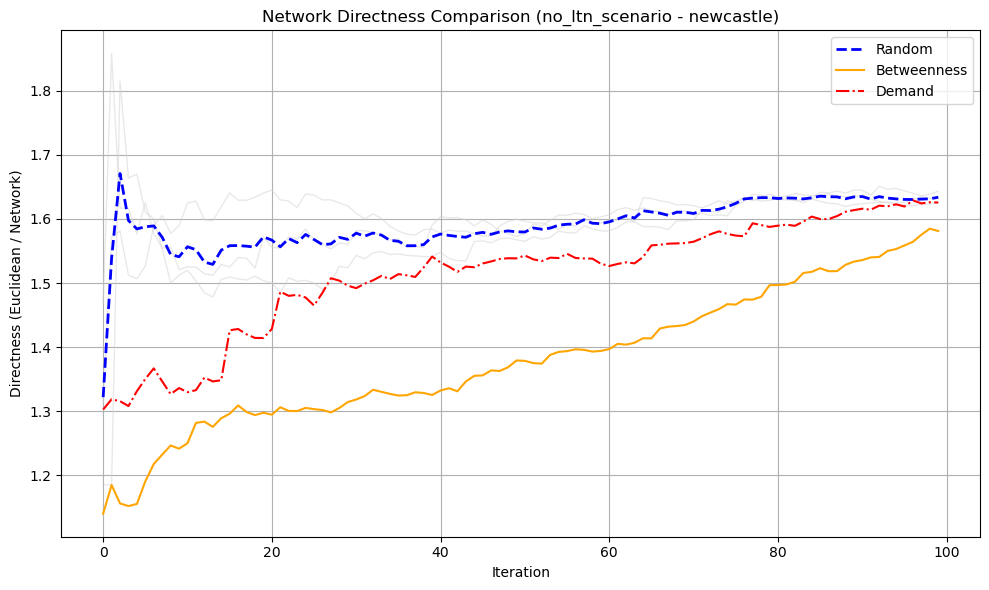

Saved directness plot for newcastle - no_ltn_scenario
Updated directness analysis for current_ltn_scenario in newcastle


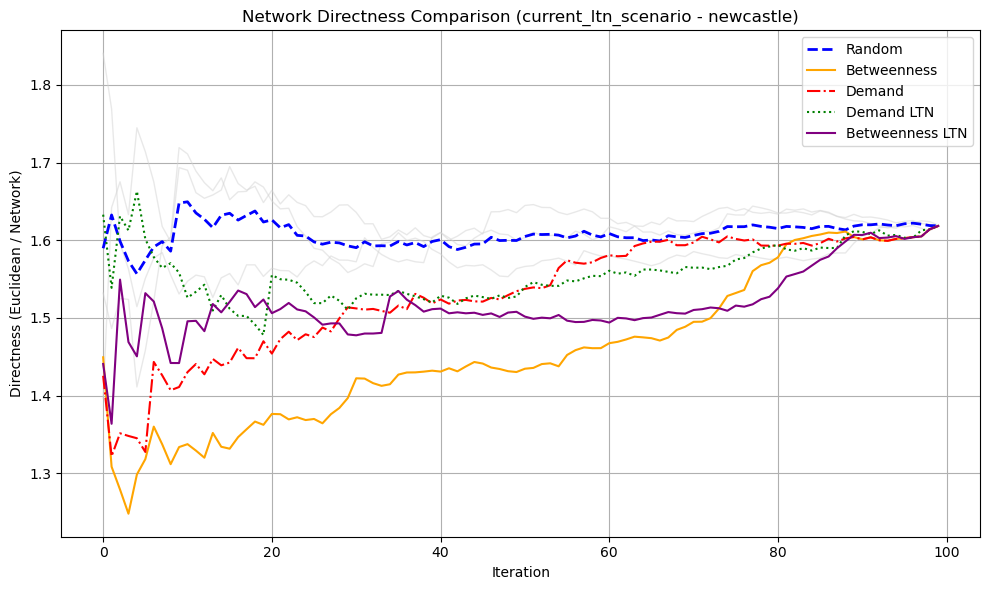

Saved directness plot for newcastle - current_ltn_scenario
Updated directness analysis for more_ltn_scenario in newcastle


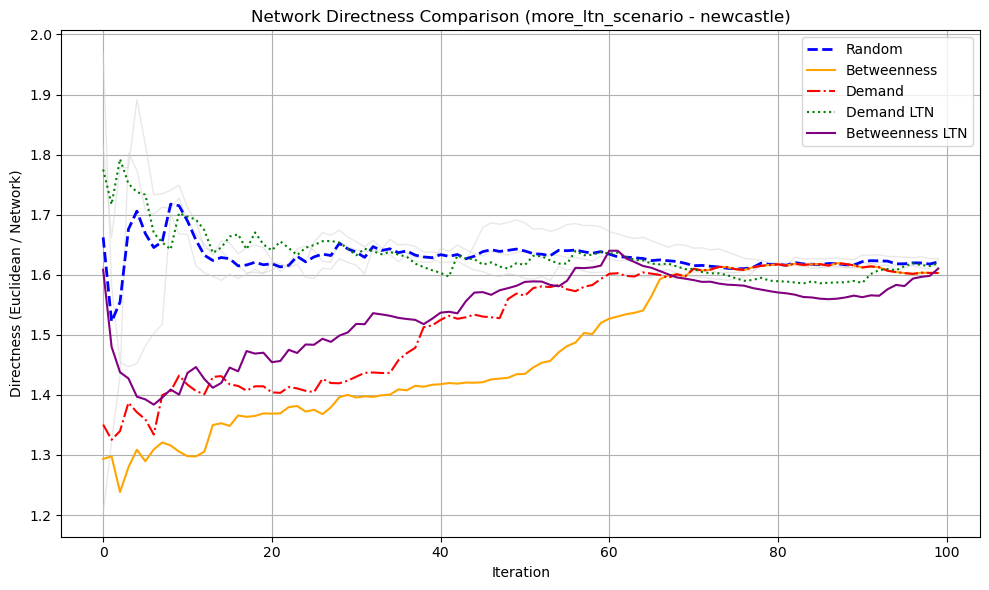

Saved directness plot for newcastle - more_ltn_scenario


In [ ]:

for scenario in params["scenarios"]:
    # load 
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json   = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)

    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GT_abstracts", [])
    GTs_demand      = demand_results[scenario].get(placeid, {}).get("GT_abstracts", [])
    if scenario != "no_ltn_scenario":
        GTs_demand_ltn_priority      = demand_ltn_priority_results[scenario].get(placeid, {}).get("GT_abstracts", [])
        GTs_betweenness_ltn_priority = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GT_abstracts", [])
    random_runs = [run["GT_abstracts"] for run in random_results[scenario].get(placeid, [])]
    if rerun or "Betweenness Growth - Directness" not in analysis_results[scenario]:
        results_list = []
        direct_betw = utils.calc_directness(GTs_betweenness)
        results_list.append(("Betweenness Growth - Directness", direct_betw))
        for i, run_graphs in enumerate(random_runs):
            direct_rand = utils.calc_directness(run_graphs)
            results_list.append((f"Random Run {i+1} - Directness", direct_rand))
        random_array = np.array([[val if val is not None else 0 for val in utils.calc_directness(run_graphs)] for run_graphs in random_runs])
        if random_array.size > 0:
            random_direct_mean = np.nanmean(random_array, axis=0).tolist()
        else:
            random_direct_mean = []
        results_list.append(("Random Growth (mean) - Directness", random_direct_mean))
        direct_demand = utils.calc_directness(GTs_demand)
        results_list.append(("Demand Growth - Directness", direct_demand))
        if scenario != "no_ltn_scenario":
            direct_demand_ltn = utils.calc_directness(GTs_demand_ltn_priority)
            results_list.append(("Demand LTN Priority Growth - Directness", direct_demand_ltn))

            direct_betw_ltn = utils.calc_directness(GTs_betweenness_ltn_priority)
            results_list.append(("Betweenness LTN Priority Growth - Directness", direct_betw_ltn))

        # save results
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Updated directness analysis for {scenario} in {placeid}")



    # plot
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Directness"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color="lightgray", linewidth=1, alpha=0.5)
        else:
            break
    plt.plot(analysis_results[scenario]["Random Growth (mean) - Directness"], "--", color="blue", linewidth=2, label="Random")
    plt.plot(analysis_results[scenario]["Betweenness Growth - Directness"], "-", color="orange", label="Betweenness")
    plt.plot(analysis_results[scenario]["Demand Growth - Directness"], "-.", color="red", label="Demand")
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Directness"], ":", color="green", label="Demand LTN")
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Directness"], "-", color="purple", label="Betweenness LTN")
    plt.xlabel("Iteration")
    plt.ylabel("Directness (Euclidean / Network)")
    plt.title(f"Network Directness Comparison ({scenario} - {placeid})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    output_path = os.path.join(PATH["plots"], placeid, scenario, "directness.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved directness plot for {placeid} - {scenario}")


In [ ]:
# calcaulate directness of existing network to compare against...

## Efficiency

### Global

In [ ]:
for scenario in params["scenarios"]:
    # load
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json   = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)
    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GT_abstracts", [])
    GTs_demand = demand_results[scenario].get(placeid, {}).get("GT_abstracts", [])
    if scenario != "no_ltn_scenario":
        GTs_demand_ltn        = demand_ltn_priority_results[scenario].get(placeid, {}).get("GT_abstracts", [])
        GTs_betweenness_ltn   = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GT_abstracts", [])
    random_runs = [run["GT_abstracts"] for run in random_results[scenario].get(placeid, [])]
    if rerun or "Betweenness Growth - Global Efficiency" not in analysis_results[scenario]:
        results_list = []
        eff_betw = [utils.calculate_global_efficiency(G, numnodepairs=1000, normalized=True, weight="length") for G in GTs_betweenness]
        results_list.append(("Betweenness Growth - Global Efficiency", eff_betw))
        for i, run_graphs in enumerate(random_runs):
            eff_rand = [utils.calculate_global_efficiency(G, numnodepairs=1000, normalized=True, weight="length") for G in run_graphs]
            results_list.append((f"Random Run {i+1} - Global Efficiency", eff_rand))
        random_array = np.array([run_series for (_, run_series) in results_list if isinstance(run_series, list) and run_series and _ .startswith("Random Run")])
        if random_array.size > 0:
            random_eff_mean = np.nanmean(random_array, axis=0).tolist()
        else:
            random_eff_mean = []
        results_list.append(("Random Growth (mean) - Global Efficiency", random_eff_mean))
        eff_demand = [utils.calculate_global_efficiency(G, numnodepairs=1000, normalized=True, weight="length") for G in GTs_demand]
        results_list.append(("Demand Growth - Global Efficiency", eff_demand))
        if scenario != "no_ltn_scenario":
            eff_demand_ltn = [utils.calculate_global_efficiency(G, numnodepairs=1000, normalized=True, weight="length") for G in GTs_demand_ltn ]
            results_list.append(("Demand LTN Priority Growth - Global Efficiency", eff_demand_ltn))
            eff_betw_ltn = [utils.calculate_global_efficiency(G, numnodepairs=1000, normalized=True, weight="length") for G in GTs_betweenness_ltn]
            results_list.append(("Betweenness LTN Priority Growth - Global Efficiency", eff_betw_ltn))

        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Updated efficiency analysis for {scenario} in {placeid}")




    # plot
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Global Efficiency"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color="lightgray", linewidth=1, alpha=0.5)
        else:
            break
    plt.plot(analysis_results[scenario]["Random Growth (mean) - Global Efficiency"], "--", color="blue", linewidth=2, label="Random Growth (mean)")
    plt.plot(analysis_results[scenario]["Betweenness Growth - Global Efficiency"], "-", color="orange", label="Betweenness Growth")
    plt.plot(analysis_results[scenario]["Demand Growth - Global Efficiency"], "-.", color="red", label="Demand Growth")
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Global Efficiency"], ":", color="green", label="Demand LTN Priority Growth")
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Global Efficiency"],"-", color="purple", label="Betweenness LTN Priority Growth")

 
    plt.xlabel("Investment Iteration")
    plt.ylabel("Global Efficiency")
    plt.title(f"Global Network Efficiency per Iteration ({scenario} - {placeid})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    output_path = os.path.join(PATH["plots"], placeid, scenario, "global_eff.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved efficiency plot for {placeid} - {scenario}")


Updated efficiency analysis for no_ltn_scenario in newcastle
Saved efficiency plot for newcastle - no_ltn_scenario
Updated efficiency analysis for current_ltn_scenario in newcastle
Saved efficiency plot for newcastle - current_ltn_scenario
Updated efficiency analysis for more_ltn_scenario in newcastle
Saved efficiency plot for newcastle - more_ltn_scenario


### Local

In [ ]:
for scenario in params["scenarios"]:
    # Load results
    analysis_res_pickle = analysis_res_pickle_paths[scenario]
    analysis_res_json   = analysis_res_json_paths[scenario]
    analysis_results[scenario] = utils.load_results(analysis_res_pickle)

    GTs_betweenness = betweenness_results[scenario].get(placeid, {}).get("GT_abstracts", [])
    GTs_demand = demand_results[scenario].get(placeid, {}).get("GT_abstracts", [])

    if scenario != "no_ltn_scenario":
        GTs_demand_ltn = demand_ltn_priority_results[scenario].get(placeid, {}).get("GT_abstracts", [])
        GTs_betweenness_ltn = betweenness_ltn_priority_results[scenario].get(placeid, {}).get("GT_abstracts", [])

    random_runs = [run["GT_abstracts"] for run in random_results[scenario].get(placeid, [])]

    if rerun or "Betweenness Growth - Local Efficiency" not in analysis_results[scenario]:
        results_list = []

        # Betweenness
        eff_betw = [utils.calculate_local_efficiency(G, numnodepairs=1000, weight="length") for G in GTs_betweenness]
        results_list.append(("Betweenness Growth - Local Efficiency", eff_betw))

        # Random runs
        for i, run_graphs in enumerate(random_runs):
            eff_rand = [utils.calculate_local_efficiency(G, numnodepairs=1000,  weight="length") for G in run_graphs]
            results_list.append((f"Random Run {i+1} - Local Efficiency", eff_rand))

        # Mean random baseline
        random_array = np.array([
            series for (label, series) in results_list
            if isinstance(series, list) and series and label.startswith("Random Run")
        ])
        random_eff_mean = np.nanmean(random_array, axis=0).tolist() if random_array.size > 0 else []
        results_list.append(("Random Growth (mean) - Local Efficiency", random_eff_mean))

        # Demand
        eff_demand = [utils.calculate_local_efficiency(G, numnodepairs=1000, weight="length") for G in GTs_demand]
        results_list.append(("Demand Growth - Local Efficiency", eff_demand))

        # LTN variants
        if scenario != "no_ltn_scenario":
            eff_demand_ltn = [utils.calculate_local_efficiency(G, numnodepairs=1000, weight="length") for G in GTs_demand_ltn]
            results_list.append(("Demand LTN Priority Growth - Local Efficiency", eff_demand_ltn))
            eff_betw_ltn = [utils.calculate_local_efficiency(G, numnodepairs=1000,  weight="length") for G in GTs_betweenness_ltn]
            results_list.append(("Betweenness LTN Priority Growth - Local Efficiency", eff_betw_ltn))

        # Save and store
        utils.save_results(results_list, analysis_res_pickle, analysis_res_json)
        analysis_results[scenario] = {label: data for label, data in results_list}
        print(f"Updated local efficiency analysis for {scenario} in {placeid}")

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(1, 100):
        key = f"Random Run {i} - Local Efficiency"
        if key in analysis_results[scenario]:
            plt.plot(analysis_results[scenario][key], color="lightgray", linewidth=1, alpha=0.5)
        else:
            break
    plt.plot(analysis_results[scenario]["Random Growth (mean) - Local Efficiency"], "--", color="blue", linewidth=2, label="Random Growth (mean)")
    plt.plot(analysis_results[scenario]["Betweenness Growth - Local Efficiency"], "-", color="orange", label="Betweenness Growth")
    plt.plot(analysis_results[scenario]["Demand Growth - Local Efficiency"], "-.", color="red", label="Demand Growth")
    if scenario != "no_ltn_scenario":
        plt.plot(analysis_results[scenario]["Demand LTN Priority Growth - Local Efficiency"], ":", color="green", label="Demand LTN Priority Growth")
        plt.plot(analysis_results[scenario]["Betweenness LTN Priority Growth - Local Efficiency"], "-", color="purple", label="Betweenness LTN Priority Growth")

    plt.xlabel("Investment Iteration")
    plt.ylabel("Local Efficiency (Normalized)")
    plt.title(f"Normalized Local Network Efficiency per Iteration ({scenario} - {placeid})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    output_path = os.path.join(PATH["plots"], placeid, scenario, "local_eff.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Saved local efficiency plot for {placeid} - {scenario}")


Updated local efficiency analysis for no_ltn_scenario in newcastle
Saved local efficiency plot for newcastle - no_ltn_scenario
Updated local efficiency analysis for current_ltn_scenario in newcastle
Saved local efficiency plot for newcastle - current_ltn_scenario
Updated local efficiency analysis for more_ltn_scenario in newcastle
Saved local efficiency plot for newcastle - more_ltn_scenario


## Cyclable trips

This is where we should calcualte the number of cycleable trips 

## Average node degree

Average number of connections per node - shows choice of direction?

# (Optional) Pretty plots of networks

Detailed plots of specific networks should go here

## Unfinshed

In [ ]:
metrics_GTs, metrics_GTs_random = compare_against_existing(GTs, GTs_random, G_biketrack_no_ltn) # no differance?
plot_comparison(metrics_GTs, metrics_GTs_random)